In [1]:
import numpy as np
from plot import plot, plot_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statistics
import networkx as nx
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from bct.algorithms import(centrality, clustering, degree, distance, modularity, core, similarity, efficiency)
from scipy.stats import pearsonr
from matplotlib.ticker import FuncFormatter

In [2]:
palette_nodewise = ['#619eff', '#a9d8fc']
palette_efficiency = ['#21d13c', '#9fedab']
palette_global = ['#b146e3', '#cf9ee6']

# Data visualisation

In [3]:
def plot_hist_distribution(dataset_t1, dataset_t2, dataset_t3, title):
    data1 = dataset_t1.flatten()
    data2 = dataset_t2.flatten()
    data3 = dataset_t3.flatten()
    
    # Plot histogram
    plt.figure(figsize=(12, 8))
    plt.hist(data1, bins=30, alpha=0.3, label='Timepoint 1', color='darkblue')
    plt.hist(data2, bins=30, alpha=0.3, label='Timepoint 2', color='forestgreen')
    plt.hist(data3, bins=30, alpha=0.3, label='Timepoint 3', color='red')

    plt.xlim(0,)
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [4]:
dataset = np.load("datasets/oasis_data.npy")
print(np.max(dataset))
dataset = np.delete(dataset,88,axis=0)
dataset_t1 = dataset[:,0,:,:]
dataset_t2 = dataset[:,1,:,:]
dataset_t3 = dataset[:,2,:,:]

165.648


In [5]:
print(dataset.shape)

(113, 3, 35, 35)


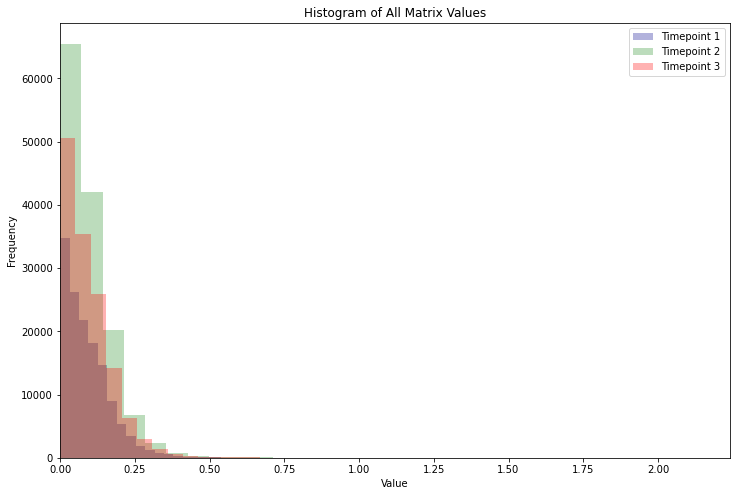

In [6]:
plot_hist_distribution(dataset_t1, dataset_t2, dataset_t3, 'Histogram of All Matrix Values')

In [7]:
def load_test_results(file_path, n_folds, dataset_size, n_times):
    mae_across_all_folds = np.zeros((n_folds, n_times))
    mem_cap_across_all_folds = np.zeros((n_folds, n_times))
    predicted_across_all_folds = []
    original_across_all_folds = []
    for f in range(n_folds):
        maes = np.load(file_path+f"test_mae_losses/mae_test_loss_fold_{f}.npy")
        mae_across_all_folds[f] = maes
        mem_caps = np.load(file_path+f"test_memcap_losses/memcap_test_loss_fold_{f}.npy")
        mem_cap_across_all_folds[f] = mem_caps
        predicted = np.load(file_path+f"test_predicted/predicted_fold_{f}.npy")    
        predicted_across_all_folds.append(predicted)
        original = np.load(file_path+f"test_original/original_fold_{f}.npy")
        original_across_all_folds.append(original)
    return mae_across_all_folds, mem_cap_across_all_folds, predicted_across_all_folds, original_across_all_folds

In [8]:
def print_mean_std(data, baseline_data):
    data_mean = statistics.mean(data)
    baseline_mean = statistics.mean(baseline_data)
    data_std = statistics.stdev(data)
    baseline_std = statistics.stdev(baseline_data)
    print(f"Mean: {statistics.mean(data)}")
    print(f"Standard Deviation {statistics.stdev(data)}")
    print(f"Baseline Mean: {statistics.mean(baseline_data)}")
    print(f"Baseline Standard Deviation {statistics.stdev(baseline_data)}")
    return data_mean, baseline_mean, data_std, baseline_std

In [9]:
def plot_comparison(data_across_all_folds, baseline_data_across_all_folds, title, y_label, timepoint, y_lim=None, palette='Set2'):
    # Extract column from the data results
    data = data_across_all_folds[:, timepoint]
    baseline_data = baseline_data_across_all_folds[:, timepoint]
    
    # Calculate the average and append to the arrays
    data_mean, baseline_mean, data_std, baseline_std = print_mean_std(data, baseline_data)
    
    data = np.append(data, data_mean)
    baseline_data = np.append(baseline_data, baseline_mean)
    
    data_dict = {
        'Fold': ['Fold 1', 'Fold 2', 'Fold 3', 'Average Across Folds'],
        'With Reservoir': data,  
        'Baseline': baseline_data    
    }
    
    df_long = pd.DataFrame(data_dict).melt(id_vars=['Fold'], var_name='Type', value_name=y_label)
    
    # Plotting
    plt.figure(figsize=(6, 6))
    plt.rcParams.update({
        'font.size': 12,
        'font.family': 'serif',
        'font.serif': ['DejaVu Serif'],
        'text.usetex': False
    })
    plt.xticks(rotation=10)

    barplot = sns.barplot(x='Fold', y=y_label, hue='Type', data=df_long, palette=palette, width=0.7)
    barplot.spines['top'].set_visible(False)
    barplot.spines['right'].set_visible(False)
    barplot.spines['left'].set_visible(False)
    barplot.spines['bottom'].set_color('#DDDDDD')

    barplot.tick_params(bottom=False, left=False)

    barplot.set_axisbelow(True)
    barplot.yaxis.grid(True, color='#EEEEEE')
    barplot.xaxis.grid(False)

    barplot.set_xlabel(barplot.get_xlabel(), labelpad=15)
    barplot.set_ylabel(barplot.get_ylabel(), labelpad=15)
    barplot.set_title(title, pad=20)

    # Adding error bars manually for the mean values only
    n_groups = len(data) - 1  # Number of groups without the mean
    x_coords = [n_groups - 0.165, n_groups + 0.15]  # X coordinates of the mean bars
    errors = [data_std, baseline_std]
    plt.errorbar(x_coords, [data_mean, baseline_mean], yerr=errors, fmt='none', c='black', capsize=5)
    # def y_axis_format(x, pos):
    #     return f'{x:.4f}'
    
    # barplot.yaxis.set_major_formatter(FuncFormatter(y_axis_format))
    if y_lim is not None:
        plt.ylim(*y_lim)
        
    barplot.legend_.remove()
    
    plt.title(title)
    plt.show()

# GConvGRU

In [10]:
file_path = '/vol/bitbucket/sx420/4D-FedGNN-Plus/results/reservoir_gconvGRU_t/'
mae_across_all_folds, mem_cap_across_all_folds,\
predicted_across_all_folds, original_across_all_folds = load_test_results(file_path, 3, 38, 2)

In [11]:
baseline_file_path = '/vol/bitbucket/sx420/4D-FedGNN-Plus/results/baseline_gconvGRU_t/'
baseline_mae_across_all_folds, baseline_mem_cap_across_all_folds,\
baseline_predicted_across_all_folds, baseline_original_across_all_folds = load_test_results(baseline_file_path, 3, 38, 2)

## MAE

Mean: 0.043110196541812876
Standard Deviation 0.0033686772770205506
Baseline Mean: 0.039040182794423506
Baseline Standard Deviation 0.00342627110595364


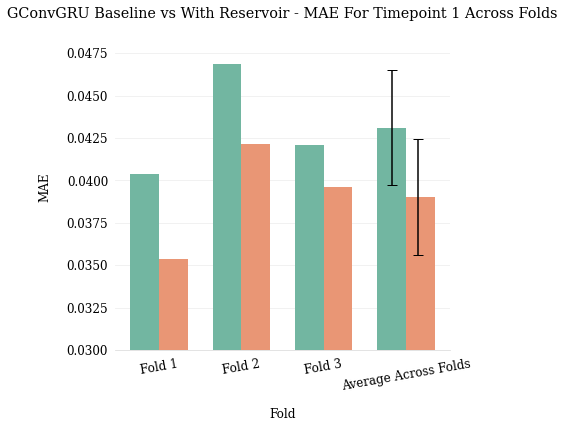

In [87]:
title = 'GConvGRU Baseline vs With Reservoir - MAE For Timepoint 1 Across Folds'
plot_comparison(mae_across_all_folds, baseline_mae_across_all_folds, title, 'MAE', 0, (0.03, ))

Mean: 0.046968168447005236
Standard Deviation 0.0036076579855485636
Baseline Mean: 0.04347019299560952
Baseline Standard Deviation 0.00375978067102504


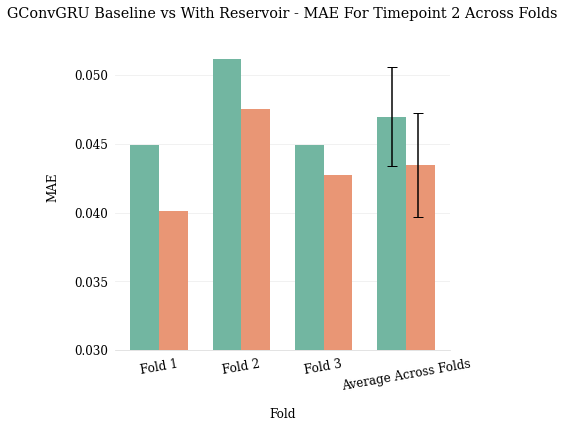

In [48]:
title = 'GConvGRU Baseline vs With Reservoir - MAE For Timepoint 2 Across Folds'
plot_comparison(mae_across_all_folds, baseline_mae_across_all_folds, title, 'MAE', 1, (0.03, ))

## MAE between Mem Caps

Mean: 0.408341098084203
Standard Deviation 0.12128856611604996
Baseline Mean: 0.5569974134297481
Baseline Standard Deviation 0.023201109161057033


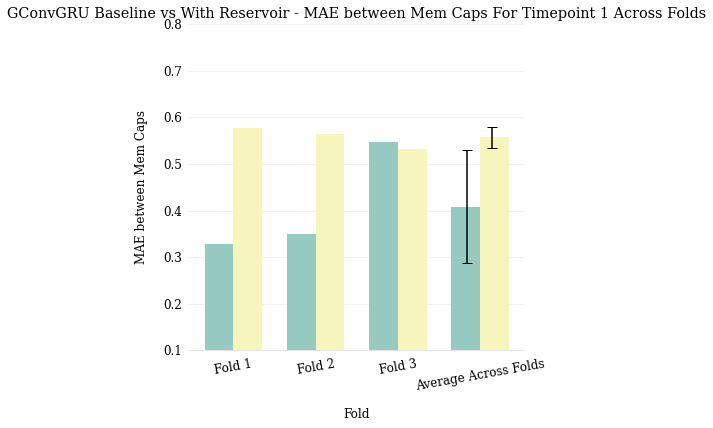

In [60]:
title = 'GConvGRU Baseline vs With Reservoir - MAE between Mem Caps For Timepoint 1 Across Folds'
plot_comparison(mem_cap_across_all_folds, baseline_mem_cap_across_all_folds, title, 'MAE between Mem Caps', 0, (0.1,0.8), 'Set3')

Mean: 0.4784916771915395
Standard Deviation 0.14195923859213144
Baseline Mean: 0.581691693056065
Baseline Standard Deviation 0.03699697522616725


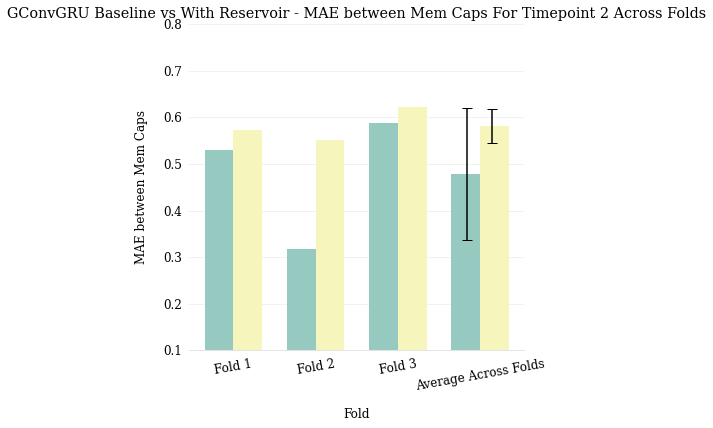

In [59]:
title = 'GConvGRU Baseline vs With Reservoir - MAE between Mem Caps For Timepoint 2 Across Folds'
plot_comparison(mem_cap_across_all_folds, baseline_mem_cap_across_all_folds, title, 'MAE between Mem Caps', 1, (0.1,0.8), 'Set3')

## Time and Memory Costs

In [82]:
baseline_gconvGRU_times = [178.28, 177.55, 183.25]
baseline_gconvGRU_memory_usage_MB = [3317.88, 3316.64, 3316.21]

In [83]:
reservoir_gconvGRU_times = [653.43, 648.17, 642.21]
reservoir_gconvGRU_memory_usage_MB = [3326.79, 3326.97, 3323.10]

In [84]:
print_mean_std(reservoir_gconvGRU_times, baseline_gconvGRU_times)

Mean: 647.9366666666666
Standard Deviation 5.613638154827299
Baseline Mean: 179.69333333333333
Baseline Standard Deviation 3.1017145796048524


(647.9366666666666, 179.69333333333333, 5.613638154827299, 3.1017145796048524)

In [85]:
print_mean_std(reservoir_gconvGRU_memory_usage_MB, baseline_gconvGRU_memory_usage_MB)

Mean: 3325.62
Standard Deviation 2.184238997912068
Baseline Mean: 3316.91
Baseline Standard Deviation 0.8671216754297605


(3325.62, 3316.91, 2.184238997912068, 0.8671216754297605)

## Network Topology Similarity

In [14]:
def node_strength_diff(G1, G2):
    mean_node_strengths_1 = statistics.mean(degree.strengths_und(G1))
    mean_node_strengths_2 = statistics.mean(degree.strengths_und(G2))
    
    return abs(mean_node_strengths_1 - mean_node_strengths_2)

In [15]:
def node_degree_diff(G1, G2):
    G1_bin = G1.astype(bool).astype(int)
    G2_bin = G2.astype(bool).astype(int)
    mean_node_degree_1 = statistics.mean(degree.degrees_und(G1_bin))
    mean_node_degree_2 = statistics.mean(degree.degrees_und(G2_bin))
    
    return abs(mean_node_degree_1 - mean_node_degree_2)

In [16]:
def global_efficiency_diff(G1, G2):
    g1 = efficiency.efficiency_wei(G1)
    g2 = efficiency.efficiency_wei(G2)
    return abs(g1 - g2)


In [17]:
def local_efficiency_diff(G1, G2):
    l1 = efficiency.efficiency_wei(G1, local=True)
    l2 = efficiency.efficiency_wei(G2, local=True)
    
    avg_l1 = statistics.mean(l1)
    avg_l2 = statistics.mean(l2)
    
    return abs(avg_l1 - avg_l2)


In [18]:
def participation_coef_diff(G1, G2):
    ci = np.arange(len(G1)) + 1
    
    p1 = centrality.participation_coef(G1, ci)
    p2 = centrality.participation_coef(G2, ci)

    
    avg_p1 = statistics.mean(p1)
    avg_p2 = statistics.mean(p2)
    
    return abs(avg_p1 - avg_p2)
    

In [19]:
def diversity_coef_diff(G1, G2):
    ci = np.arange(len(G1)) + 1
    
    d1_pos, d1_neg = centrality.diversity_coef_sign(G1, ci)
    d2_pos, d2_neg = centrality.diversity_coef_sign(G2, ci)

    
    avg_d1_pos = statistics.mean(d1_pos)
    avg_d2_pos = statistics.mean(d2_pos)
    
    avg_d1_neg = statistics.mean(d1_neg)
    avg_d2_neg = statistics.mean(d2_neg)
    
    return abs(avg_d1_pos - avg_d2_pos) + abs(avg_d1_neg - avg_d2_neg)
    

In [20]:
def betweeness_centrality_diff(G1, G2):  
    betweenness_centrality1 = centrality.betweenness_wei(G1)
    betweenness_centrality2 = centrality.betweenness_wei(G2)
    
    mean_bc1 = statistics.mean(betweenness_centrality1)
    mean_bc2 = statistics.mean(betweenness_centrality2)
    return abs(mean_bc1 - mean_bc2)


In [21]:
def eigenvector_centrality_diff(G1, G2):
    ec1 = centrality.eigenvector_centrality_und(G1)
    ec2 = centrality.eigenvector_centrality_und(G2)
    
    mean_ec1 = statistics.mean(ec1)
    mean_ec2 = statistics.mean(ec2)
    return abs(mean_ec1 - mean_ec2)

In [22]:
def modularity_diff(G1, G2):
    G1 = nx.from_numpy_array(G1)
    G2 = nx.from_numpy_array(G2)
    
    communities_1 = nx.algorithms.community.greedy_modularity_communities(G1)
    modularity_1 = nx.algorithms.community.modularity(G1, communities_1)
    
    communities_2 = nx.algorithms.community.greedy_modularity_communities(G2)
    modularity_2 = nx.algorithms.community.modularity(G2, communities_2)
    
    return abs(modularity_1 - modularity_2)

In [23]:
def density_diff(G1, G2):
    G1 = nx.from_numpy_array(G1)
    G2 = nx.from_numpy_array(G2)
    
    density_1 = nx.density(G1)
    density_2 = nx.density(G2)
    
    return abs(density_1 - density_2)

In [24]:
def clustering_diff(G1, G2):
    clustering_1 = clustering.transitivity_wu(G1)
    clustering_2 = clustering.transitivity_wu(G2)
    
    return abs(clustering_1 - clustering_2)

In [25]:
def get_diffs_across_folds(diff_func, predicted_across_all_folds, original_across_all_folds):
    total_diff_folds = np.zeros((len(predicted_across_all_folds), 2))
    for f, (predicted_f, actual_f) in enumerate(zip(predicted_across_all_folds, original_across_all_folds)):
        for n_t in range(2):
            total_diff = 0
            for n_subjects in range(predicted_f.shape[0]):
                predicted = predicted_f[n_subjects, n_t, :, :]
                actual = actual_f[n_subjects, n_t, :, :]
                
                total_diff += diff_func(predicted, actual)
            total_diff_folds[f, n_t] = total_diff / predicted_f.shape[0]
    return total_diff_folds

### Node Strength

Mean: 0.577426457086133
Standard Deviation 0.19161155029377597
Baseline Mean: 0.4525613058301226
Baseline Standard Deviation 0.18144228924605427


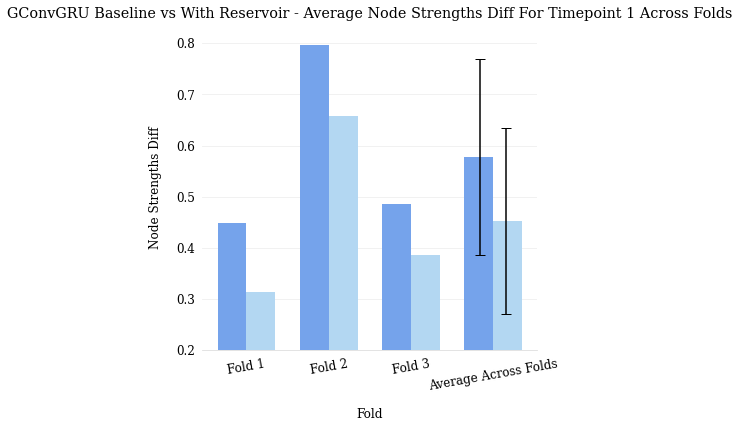

Mean: 0.742463303838851
Standard Deviation 0.22750353178363442
Baseline Mean: 0.6780700955473552
Baseline Standard Deviation 0.25552495700515165


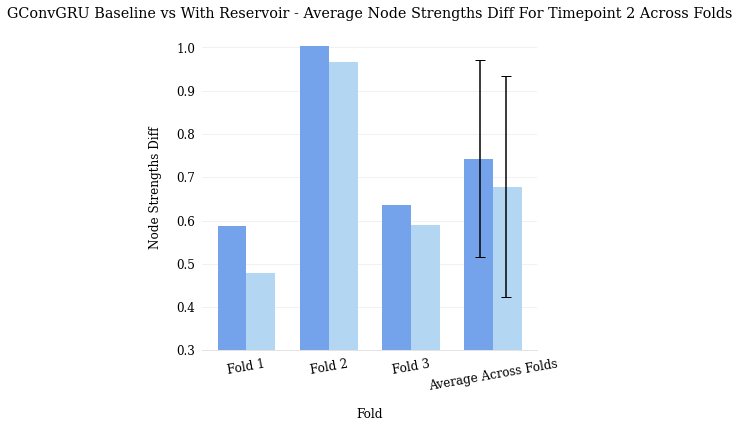

In [120]:
reservoir_node_strength_diff = get_diffs_across_folds(node_strength_diff, predicted_across_all_folds, original_across_all_folds)
baseline_node_strength_diff = get_diffs_across_folds(node_strength_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'GConvGRU Baseline vs With Reservoir - Average Node Strengths Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_node_strength_diff, baseline_node_strength_diff, title, 'Node Strengths Diff', 0, (0.2,), palette_nodewise)
title = 'GConvGRU Baseline vs With Reservoir - Average Node Strengths Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_node_strength_diff, baseline_node_strength_diff, title, 'Node Strengths Diff', 1, (0.3,), palette_nodewise)

### Centrality

Mean: 0.005681453434811104
Standard Deviation 0.002143485058423384
Baseline Mean: 0.006954283934431593
Baseline Standard Deviation 0.0011454623404985496


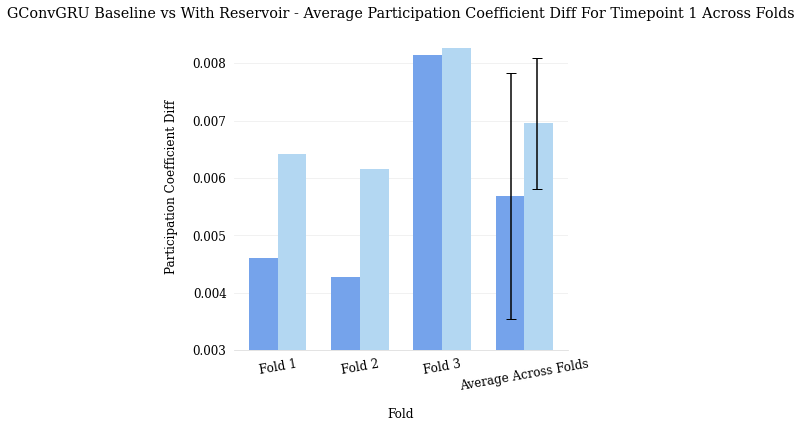

Mean: 0.006407128775270256
Standard Deviation 0.000792185368885909
Baseline Mean: 0.0073251403204187505
Baseline Standard Deviation 0.0011546555361658484


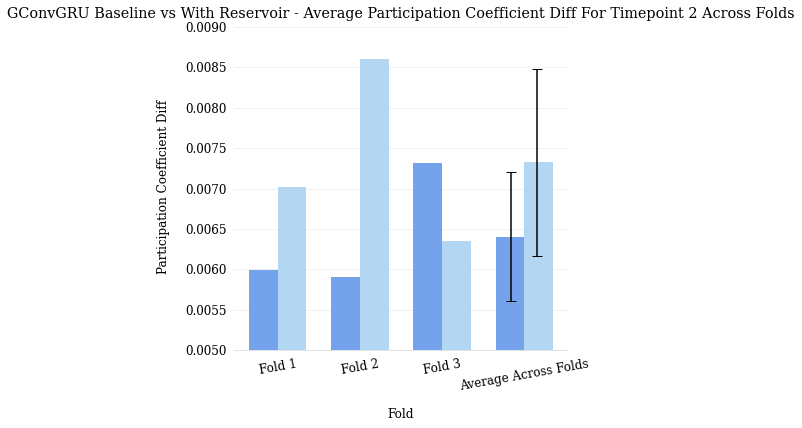

In [121]:
reservoir_participation_coef_diff = get_diffs_across_folds(participation_coef_diff, predicted_across_all_folds, original_across_all_folds)
baseline_participation_coef_diff = get_diffs_across_folds(participation_coef_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'GConvGRU Baseline vs With Reservoir - Average Participation Coefficient Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_participation_coef_diff, baseline_participation_coef_diff, title, 'Participation Coefficient Diff', 0, (0.003, ), palette_nodewise)
title = 'GConvGRU Baseline vs With Reservoir - Average Participation Coefficient Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_participation_coef_diff, baseline_participation_coef_diff, title, 'Participation Coefficient Diff', 1, (0.005,), palette_nodewise)

Mean: 0.023727463569929566
Standard Deviation 0.00825355425607016
Baseline Mean: 0.03517276820285144
Baseline Standard Deviation 0.002065990011678303


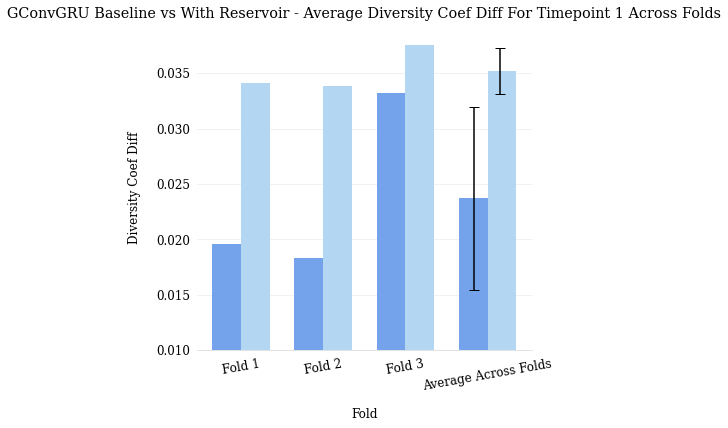

Mean: 0.025624285912864992
Standard Deviation 0.005725298184879579
Baseline Mean: 0.03469137697443363
Baseline Standard Deviation 0.004157850052793524


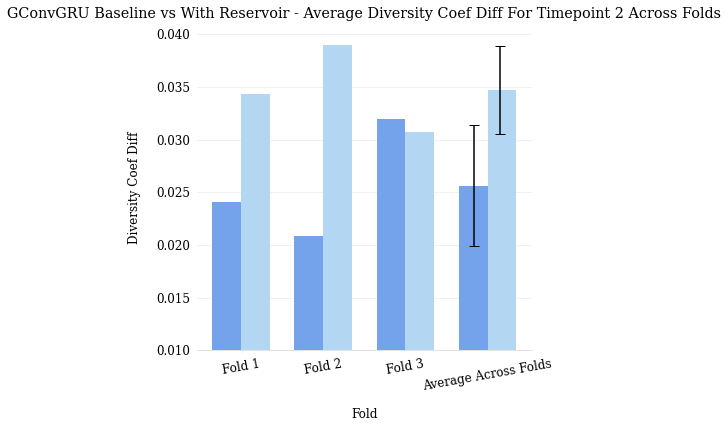

In [122]:
reservoir_diversity_coef_diff = get_diffs_across_folds(diversity_coef_diff, predicted_across_all_folds, original_across_all_folds)
baseline_diversity_coef_diff = get_diffs_across_folds(diversity_coef_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'GConvGRU Baseline vs With Reservoir - Average Diversity Coef Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_diversity_coef_diff, baseline_diversity_coef_diff, title, 'Diversity Coef Diff', 0, (0.01,), palette_nodewise)
title = 'GConvGRU Baseline vs With Reservoir - Average Diversity Coef Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_diversity_coef_diff, baseline_diversity_coef_diff, title, 'Diversity Coef Diff', 1, (0.01,), palette_nodewise)

In [123]:
reservoir_betweeness_centrality_diff = get_diffs_across_folds(betweeness_centrality_diff, predicted_across_all_folds, original_across_all_folds)
baseline_betweeness_centrality_diff = get_diffs_across_folds(betweeness_centrality_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 77.40391538496803
Standard Deviation 1.7208993942101878
Baseline Mean: 71.9792862445494
Baseline Standard Deviation 1.5987672173244283


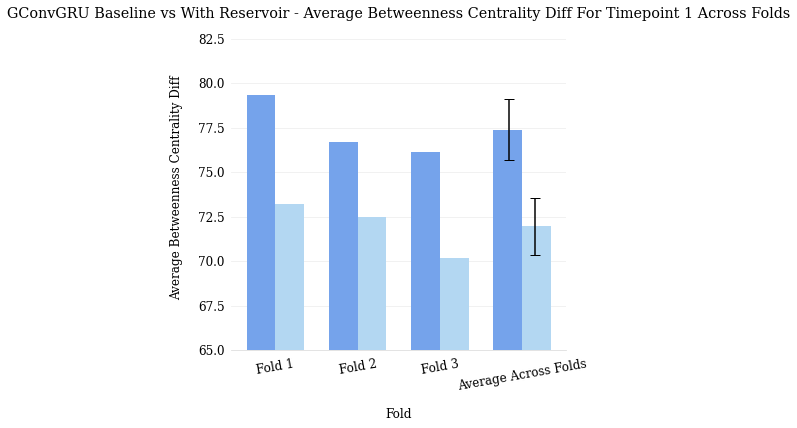

Mean: 82.392189811062
Standard Deviation 2.9033177326543336
Baseline Mean: 76.69922767599459
Baseline Standard Deviation 1.7681822828150586


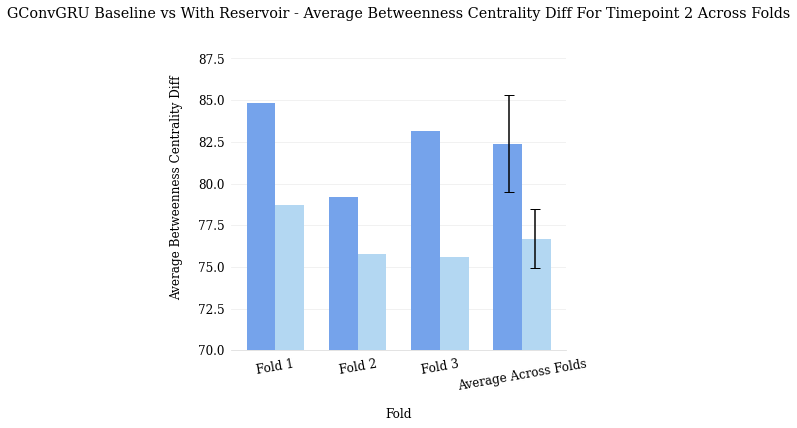

In [124]:
title = 'GConvGRU Baseline vs With Reservoir - Average Betweenness Centrality Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_betweeness_centrality_diff, baseline_betweeness_centrality_diff, title, 'Average Betweenness Centrality Diff', 0, (65,), palette_nodewise)
title = 'GConvGRU Baseline vs With Reservoir - Average Betweenness Centrality Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_betweeness_centrality_diff, baseline_betweeness_centrality_diff, title, 'Average Betweenness Centrality Diff', 1, (70,), palette_nodewise)

Mean: 0.003060623550356219
Standard Deviation 0.0005689496508504361
Baseline Mean: 0.0025424373633600064
Baseline Standard Deviation 0.000520661549915112


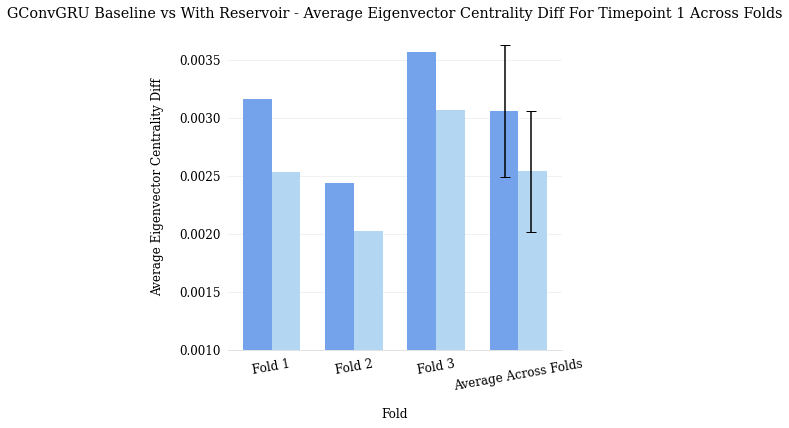

Mean: 0.004281077202789799
Standard Deviation 0.000514428590492079
Baseline Mean: 0.0031536283047716796
Baseline Standard Deviation 0.00028318360794354533


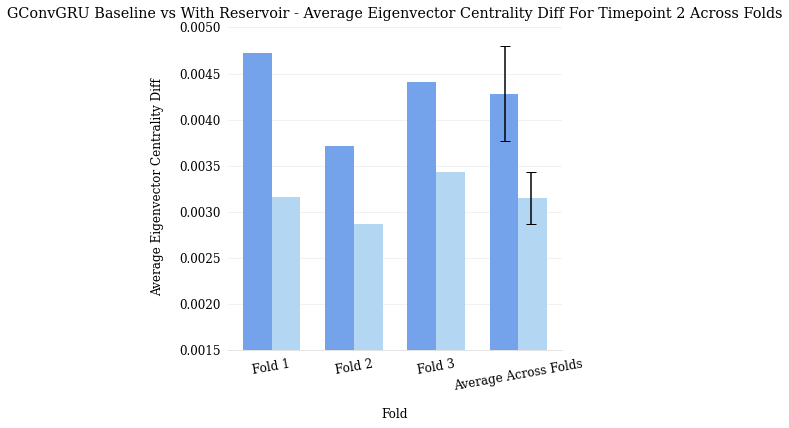

In [125]:
reservoir_eigenvector_centrality_diff = get_diffs_across_folds(eigenvector_centrality_diff, predicted_across_all_folds, original_across_all_folds)
baseline_eigenvector_centrality_diff = get_diffs_across_folds(eigenvector_centrality_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'GConvGRU Baseline vs With Reservoir - Average Eigenvector Centrality Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_eigenvector_centrality_diff, baseline_eigenvector_centrality_diff, title, 'Average Eigenvector Centrality Diff', 0, (0.001,), palette_nodewise)
title = 'GConvGRU Baseline vs With Reservoir - Average Eigenvector Centrality Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_eigenvector_centrality_diff, baseline_eigenvector_centrality_diff, title, 'Average Eigenvector Centrality Diff', 1, (0.0015,), palette_nodewise)

### Efficiency

In [126]:
reservoir_global_efficiency_diff = get_diffs_across_folds(global_efficiency_diff, predicted_across_all_folds, original_across_all_folds)
baseline_global_efficiency_diff = get_diffs_across_folds(global_efficiency_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 0.051498738019349226
Standard Deviation 0.008849281606714124
Baseline Mean: 0.04133591742992935
Baseline Standard Deviation 0.009733360784668414


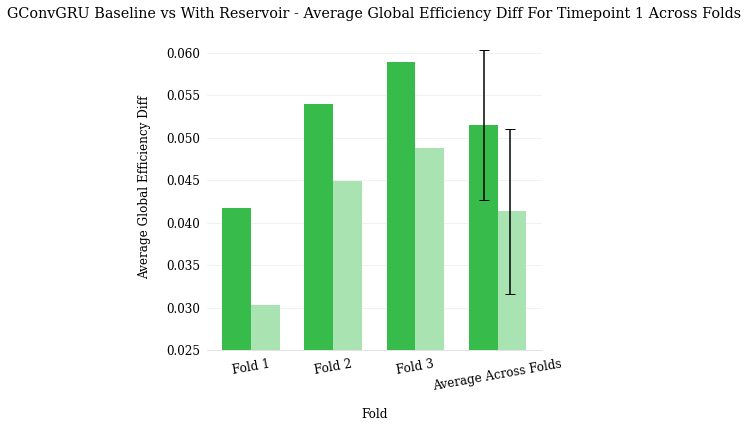

Mean: 0.0663901184188008
Standard Deviation 0.014014625956786665
Baseline Mean: 0.05807810465221944
Baseline Standard Deviation 0.016403355633937234


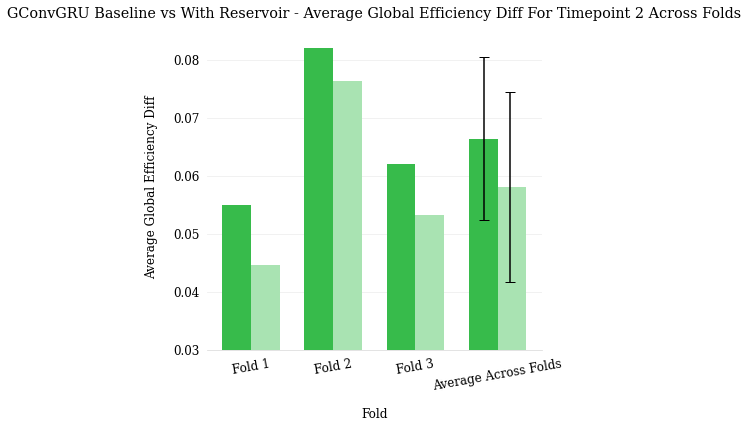

In [127]:
title = 'GConvGRU Baseline vs With Reservoir - Average Global Efficiency Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_global_efficiency_diff, baseline_global_efficiency_diff, title, 'Average Global Efficiency Diff', 0, (0.025,), palette_efficiency)
title = 'GConvGRU Baseline vs With Reservoir - Average Global Efficiency Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_global_efficiency_diff, baseline_global_efficiency_diff, title, 'Average Global Efficiency Diff', 1, (0.03,), palette_efficiency)

In [128]:
reservoir_local_efficiency_diff = get_diffs_across_folds(local_efficiency_diff, predicted_across_all_folds, original_across_all_folds)
baseline_local_efficiency_diff = get_diffs_across_folds(local_efficiency_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 0.011611701045887034
Standard Deviation 0.003327172473134743
Baseline Mean: 0.010479684019106318
Baseline Standard Deviation 0.0034324668223999523


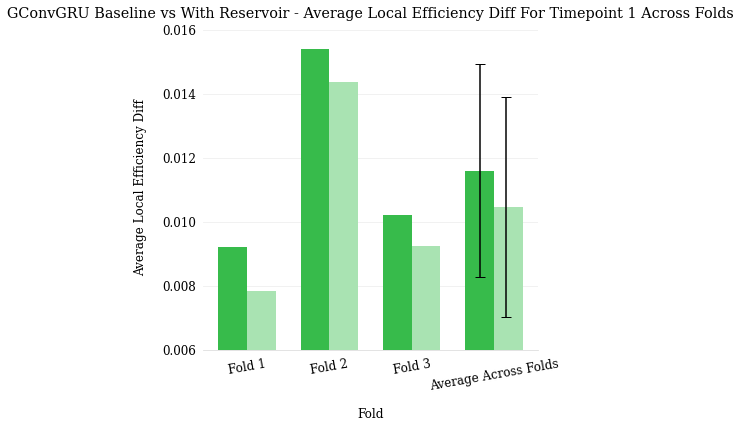

Mean: 0.01487601236305315
Standard Deviation 0.004734564401251385
Baseline Mean: 0.015130274843135463
Baseline Standard Deviation 0.005542273513901218


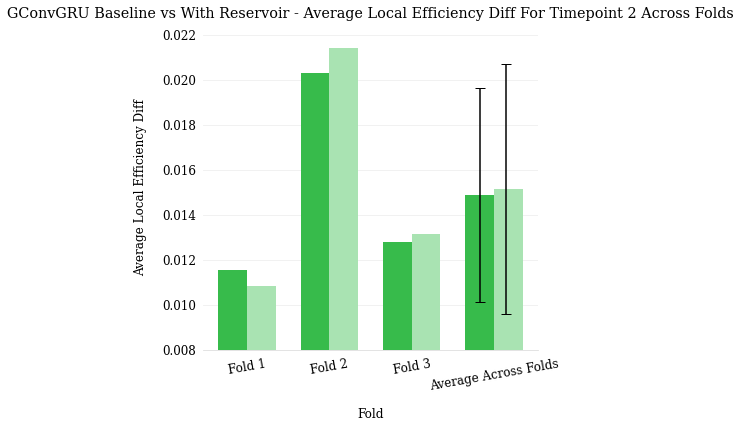

In [129]:
title = 'GConvGRU Baseline vs With Reservoir - Average Local Efficiency Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_local_efficiency_diff, baseline_local_efficiency_diff, title, 'Average Local Efficiency Diff', 0, (0.006,), palette_efficiency)
title = 'GConvGRU Baseline vs With Reservoir - Average Local Efficiency Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_local_efficiency_diff, baseline_local_efficiency_diff, title, 'Average Local Efficiency Diff', 1, (0.008,), palette_efficiency)

### Modularity

In [130]:
reservoir_modularity_diff = get_diffs_across_folds(modularity_diff, predicted_across_all_folds, original_across_all_folds)
baseline_modularity_diff = get_diffs_across_folds(modularity_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 0.0028180741346780294
Standard Deviation 0.0002744000520920756
Baseline Mean: 0.0040347272110953444
Baseline Standard Deviation 0.0005600492486639809


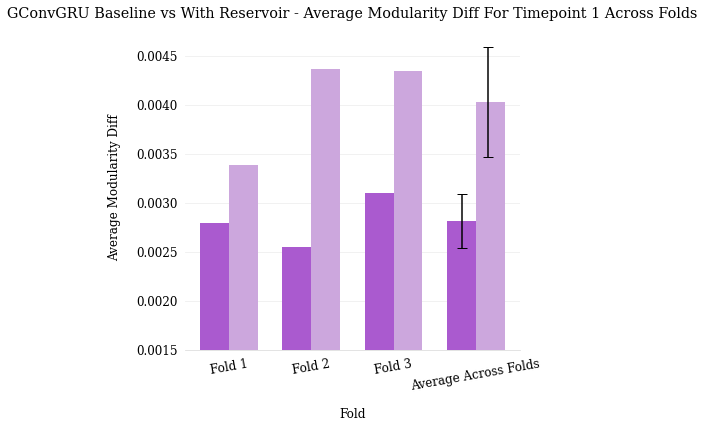

Mean: 0.0034871026454738802
Standard Deviation 0.0005538951284450424
Baseline Mean: 0.0030087773877164516
Baseline Standard Deviation 0.0003708466064075895


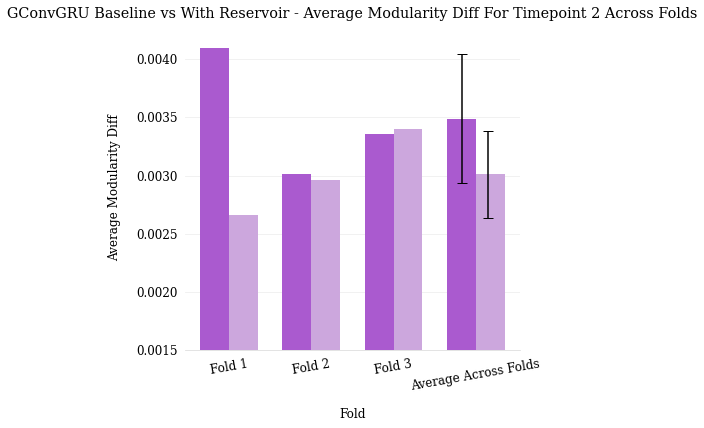

In [135]:
title = 'GConvGRU Baseline vs With Reservoir - Average Modularity Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_modularity_diff, baseline_modularity_diff, title, 'Average Modularity Diff', 0, (0.0015,), palette_global)
title = 'GConvGRU Baseline vs With Reservoir - Average Modularity Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_modularity_diff, baseline_modularity_diff, title, 'Average Modularity Diff', 1, (0.0015,), palette_global)           

### Density

Mean: 0.04913754975674485
Standard Deviation 0.0015212192412136028
Baseline Mean: 0.054811910539464735
Baseline Standard Deviation 0.0010827264454731779


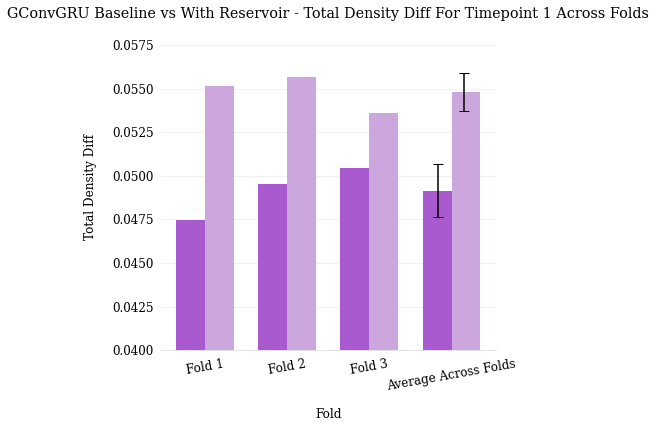

Mean: 0.0491228070175439
Standard Deviation 0.0015456691637424328
Baseline Mean: 0.05326432137577651
Baseline Standard Deviation 0.0018083413572120512


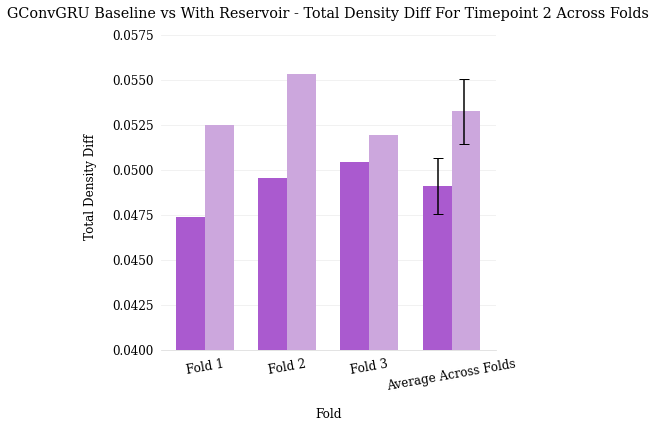

In [136]:
reservoir_density_diff = get_diffs_across_folds(density_diff, predicted_across_all_folds, original_across_all_folds)
baseline_density_diff = get_diffs_across_folds(density_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'GConvGRU Baseline vs With Reservoir - Total Density Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_density_diff, baseline_density_diff, title, 'Total Density Diff', 0, (0.04,), palette_global)
title = 'GConvGRU Baseline vs With Reservoir - Total Density Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_density_diff, baseline_density_diff, title, 'Total Density Diff', 1, (0.04,), palette_global)


### Clustering

Mean: 0.011111377224629607
Standard Deviation 0.003378040939158856
Baseline Mean: 0.009794110455087594
Baseline Standard Deviation 0.0022658610825229434


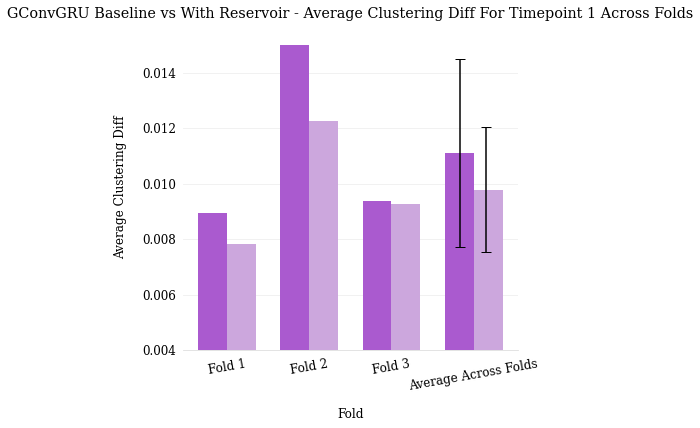

Mean: 0.014098221518367867
Standard Deviation 0.005123122550631863
Baseline Mean: 0.012867225563959445
Baseline Standard Deviation 0.0041989165780098306


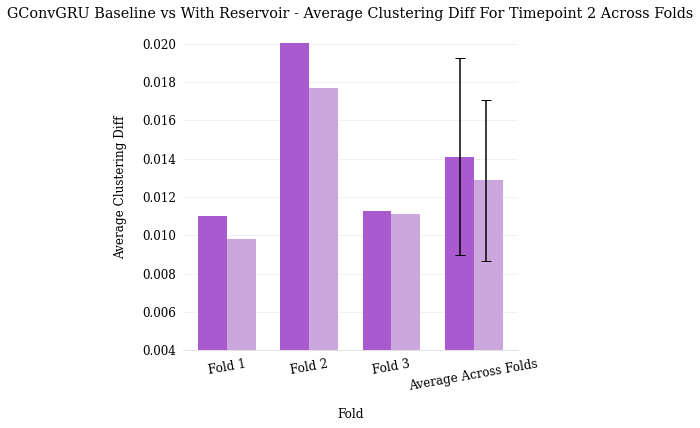

In [133]:
reservoir_clustering_diff = get_diffs_across_folds(clustering_diff, predicted_across_all_folds, original_across_all_folds)
baseline_clustering_diff = get_diffs_across_folds(clustering_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

title = 'GConvGRU Baseline vs With Reservoir - Average Clustering Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_clustering_diff, baseline_clustering_diff, title, 'Average Clustering Diff', 0, (0.004,), palette_global)
title = 'GConvGRU Baseline vs With Reservoir - Average Clustering Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_clustering_diff, baseline_clustering_diff, title, 'Average Clustering Diff', 1, (0.004,), palette_global)

## GConvLSTM

In [137]:
file_path = '/vol/bitbucket/sx420/4D-FedGNN-Plus/results/reservoir_gcLSTM_oasis_t/'
mae_across_all_folds, mem_cap_across_all_folds,\
predicted_across_all_folds, original_across_all_folds = load_test_results(file_path, 3, 38, 2)

baseline_file_path = '/vol/bitbucket/sx420/4D-FedGNN-Plus/results/baseline_gcLSTM_oasis_t/'
baseline_mae_across_all_folds, baseline_mem_cap_across_all_folds,\
baseline_predicted_across_all_folds, baseline_original_across_all_folds = load_test_results(baseline_file_path, 3, 38, 2)

Mean: 0.048669157547089316
Standard Deviation 0.0020311111508772854
Baseline Mean: 0.04697692575133655
Baseline Standard Deviation 0.003908442882853722


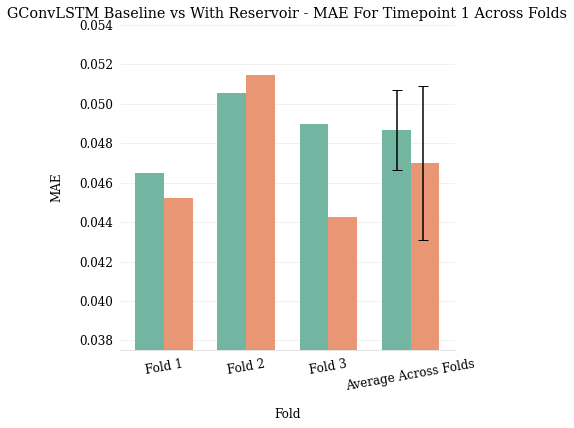

Mean: 0.052767517584768615
Standard Deviation 0.002125117723889178
Baseline Mean: 0.051271277702832574
Baseline Standard Deviation 0.004423383053421891


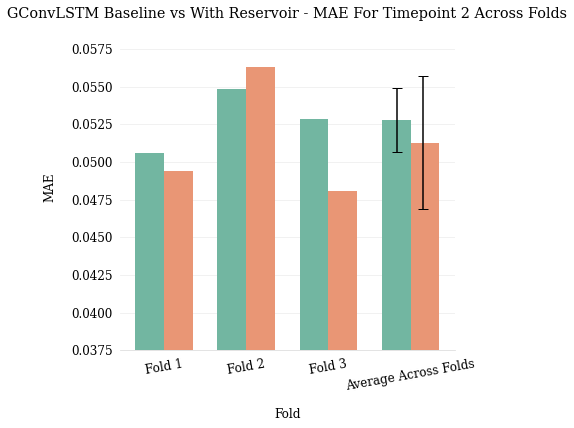

In [65]:
title = 'GConvLSTM Baseline vs With Reservoir - MAE For Timepoint 1 Across Folds'
plot_comparison(mae_across_all_folds, baseline_mae_across_all_folds, title, 'MAE', 0, (0.0375, ))
title = 'GConvLSTM Baseline vs With Reservoir - MAE For Timepoint 2 Across Folds'
plot_comparison(mae_across_all_folds, baseline_mae_across_all_folds, title, 'MAE', 1, (0.0375,))

Mean: 0.5427597052141898
Standard Deviation 0.11095023083187895
Baseline Mean: 0.588747553996971
Baseline Standard Deviation 0.167328479497186


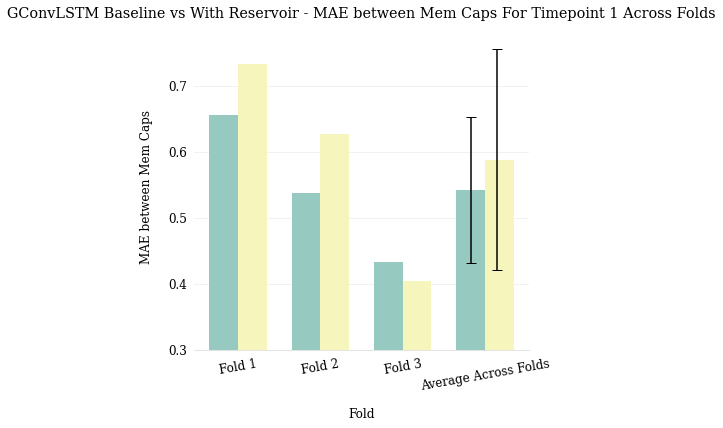

Mean: 0.6820093171745795
Standard Deviation 0.027910125203493688
Baseline Mean: 0.7167868490402105
Baseline Standard Deviation 0.12103979515717378


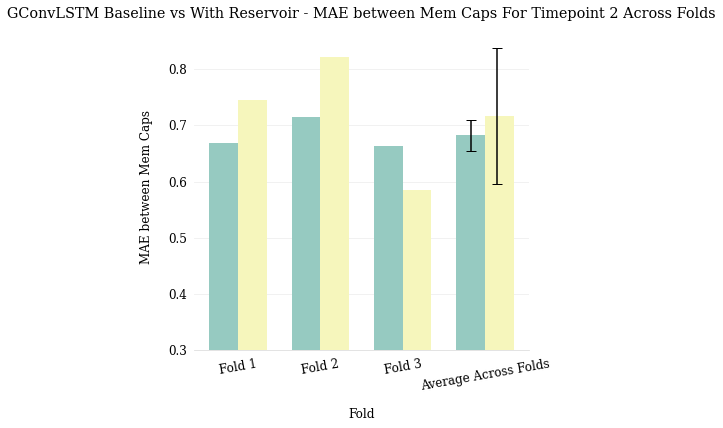

In [92]:
title = 'GConvLSTM Baseline vs With Reservoir - MAE between Mem Caps For Timepoint 1 Across Folds'
plot_comparison(mem_cap_across_all_folds, baseline_mem_cap_across_all_folds, title, 'MAE between Mem Caps', 0, (0.3,), 'Set3')
title = 'GConvLSTM Baseline vs With Reservoir - MAE between Mem Caps For Timepoint 2 Across Folds'
plot_comparison(mem_cap_across_all_folds, baseline_mem_cap_across_all_folds, title, 'MAE between Mem Caps', 1, (0.3,), 'Set3')

### Time and Memory Costs

In [55]:
baseline_gcLSTM_times = [251.36, 250.04, 255.18]
baseline_gcLSTM_memory_usage_MB = [2593.57, 2599.73, 2601.97]
reservoir_gcLSTM_times = [1095.25, 963.65, 967.69]
reservoir_gcLSTM_memory_usage_MB = [2594.49, 2603.62, 2605.46]
print_mean_std(reservoir_gcLSTM_times, baseline_gcLSTM_times)
print_mean_std(reservoir_gcLSTM_memory_usage_MB, baseline_gcLSTM_memory_usage_MB)

Mean: 1008.8633333333333
Standard Deviation 74.84031355715535
Baseline Mean: 252.19333333333333
Baseline Standard Deviation 2.669406925392485
Mean: 2601.19
Standard Deviation 5.8748531896551555
Baseline Mean: 2598.423333333333
Baseline Standard Deviation 4.349773940486086


(2601.19, 2598.423333333333, 5.8748531896551555, 4.349773940486086)

### Node Strength

Mean: 0.851829960892137
Standard Deviation 0.08043742494852513
Baseline Mean: 0.7570650799349372
Baseline Standard Deviation 0.17962043254483753


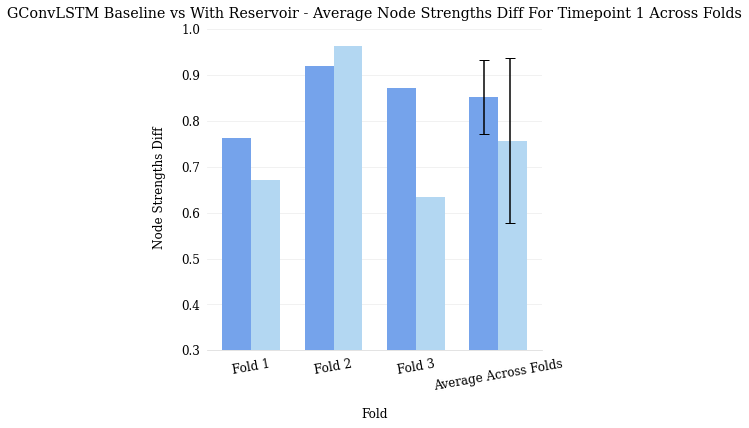

Mean: 1.0367440544992514
Standard Deviation 0.20752401684942787
Baseline Mean: 0.973782639352871
Baseline Standard Deviation 0.2721236733744069


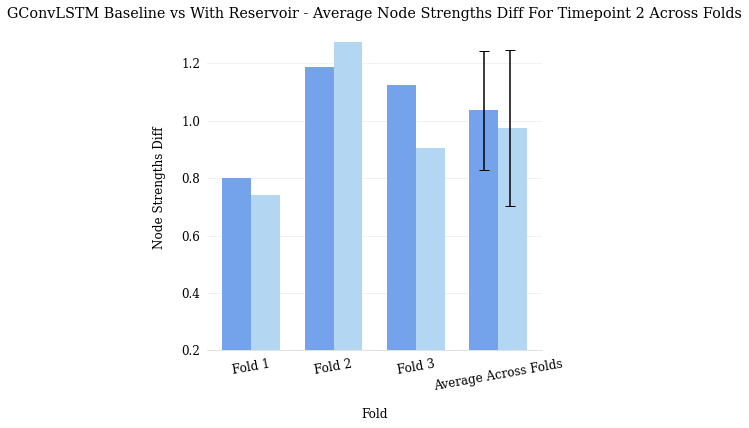

In [138]:
reservoir_node_strength_diff = get_diffs_across_folds(node_strength_diff, predicted_across_all_folds, original_across_all_folds)
baseline_node_strength_diff = get_diffs_across_folds(node_strength_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'GConvLSTM Baseline vs With Reservoir - Average Node Strengths Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_node_strength_diff, baseline_node_strength_diff, title, 'Node Strengths Diff', 0, (0.3,), palette_nodewise)
title = 'GConvLSTM Baseline vs With Reservoir - Average Node Strengths Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_node_strength_diff, baseline_node_strength_diff, title, 'Node Strengths Diff', 1, (0.2,), palette_nodewise)

### Centrality

Mean: 0.0024702308174144507
Standard Deviation 0.0010624999124507614
Baseline Mean: 0.0035090062138578046
Baseline Standard Deviation 0.00157092491682548


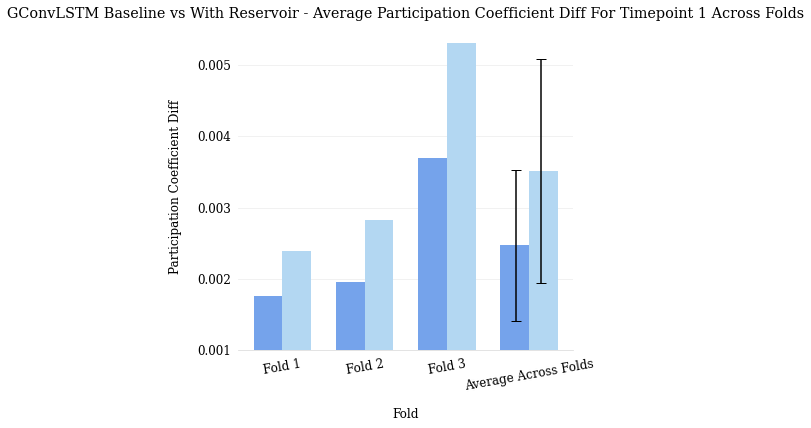

Mean: 0.0029782783372756384
Standard Deviation 0.00045358010064912405
Baseline Mean: 0.0038836470829536392
Baseline Standard Deviation 0.0005132956730618648


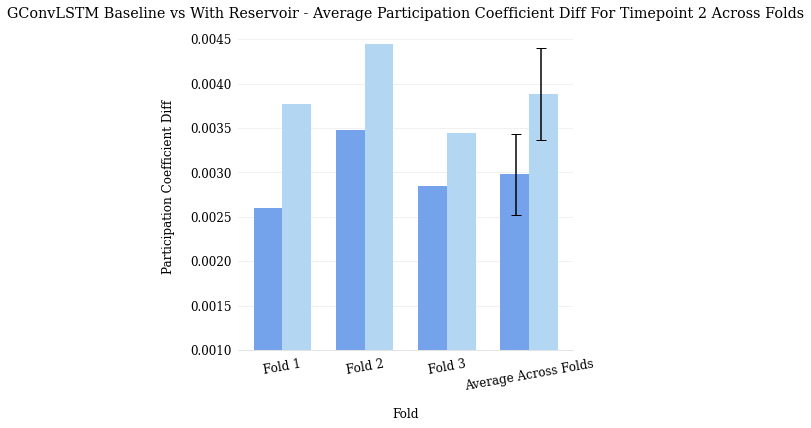

In [139]:
reservoir_participation_coef_diff = get_diffs_across_folds(participation_coef_diff, predicted_across_all_folds, original_across_all_folds)
baseline_participation_coef_diff = get_diffs_across_folds(participation_coef_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'GConvLSTM Baseline vs With Reservoir - Average Participation Coefficient Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_participation_coef_diff, baseline_participation_coef_diff, title, 'Participation Coefficient Diff', 0, (0.001,), palette_nodewise)
title = 'GConvLSTM Baseline vs With Reservoir - Average Participation Coefficient Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_participation_coef_diff, baseline_participation_coef_diff, title, 'Participation Coefficient Diff', 1, (0.001,), palette_nodewise)

Mean: 0.0103847028638597
Standard Deviation 0.00221885996208009
Baseline Mean: 0.013963645798355129
Baseline Standard Deviation 0.007354697476640817


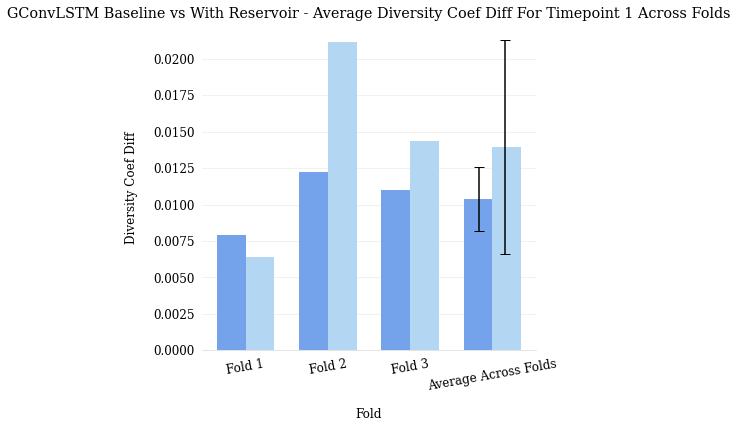

Mean: 0.009706983217625541
Standard Deviation 0.0031609359130673094
Baseline Mean: 0.013856509003089911
Baseline Standard Deviation 0.007817735507362226


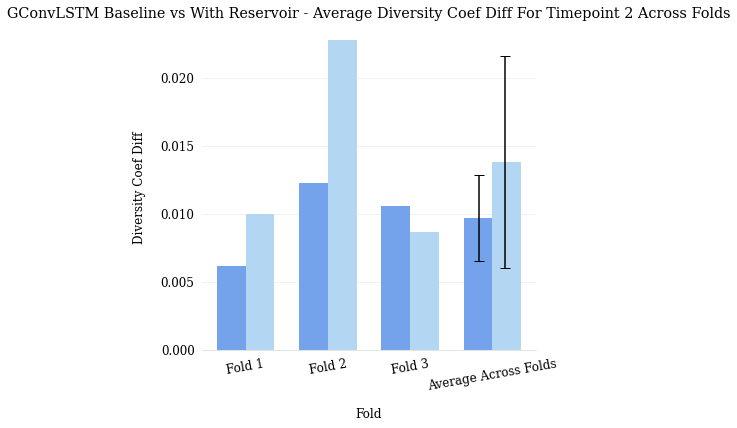

In [140]:
reservoir_diversity_coef_diff = get_diffs_across_folds(diversity_coef_diff, predicted_across_all_folds, original_across_all_folds)
baseline_diversity_coef_diff = get_diffs_across_folds(diversity_coef_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'GConvLSTM Baseline vs With Reservoir - Average Diversity Coef Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_diversity_coef_diff, baseline_diversity_coef_diff, title, 'Diversity Coef Diff', 0, (0,), palette_nodewise)
title = 'GConvLSTM Baseline vs With Reservoir - Average Diversity Coef Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_diversity_coef_diff, baseline_diversity_coef_diff, title, 'Diversity Coef Diff', 1, (0,), palette_nodewise)

In [141]:
reservoir_betweeness_centrality_diff = get_diffs_across_folds(betweeness_centrality_diff, predicted_across_all_folds, original_across_all_folds)
baseline_betweeness_centrality_diff = get_diffs_across_folds(betweeness_centrality_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 77.86088212614528
Standard Deviation 1.6931980359193712
Baseline Mean: 78.2365781228939
Baseline Standard Deviation 2.436106582802564


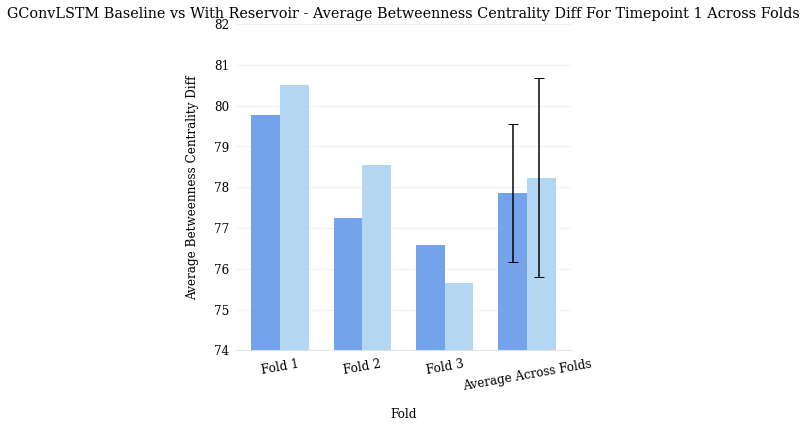

Mean: 83.37020241012722
Standard Deviation 3.593928993281401
Baseline Mean: 83.19991859247497
Baseline Standard Deviation 3.222376468175957


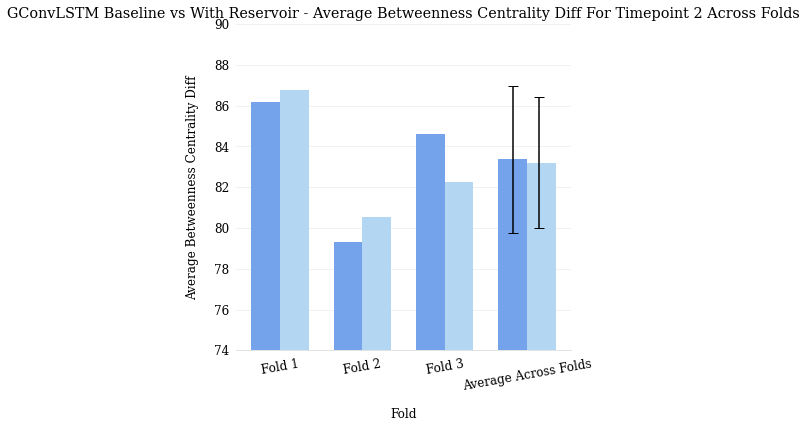

In [148]:
title = 'GConvLSTM Baseline vs With Reservoir - Average Betweenness Centrality Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_betweeness_centrality_diff, baseline_betweeness_centrality_diff, title, 'Average Betweenness Centrality Diff', 0, (74, 82), palette_nodewise)
title = 'GConvLSTM Baseline vs With Reservoir - Average Betweenness Centrality Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_betweeness_centrality_diff, baseline_betweeness_centrality_diff, title, 'Average Betweenness Centrality Diff', 1, (74, 90), palette_nodewise)

Mean: 0.0032251626901319023
Standard Deviation 0.0006606080528044135
Baseline Mean: 0.0032800997079329543
Baseline Standard Deviation 0.0007657764923245738


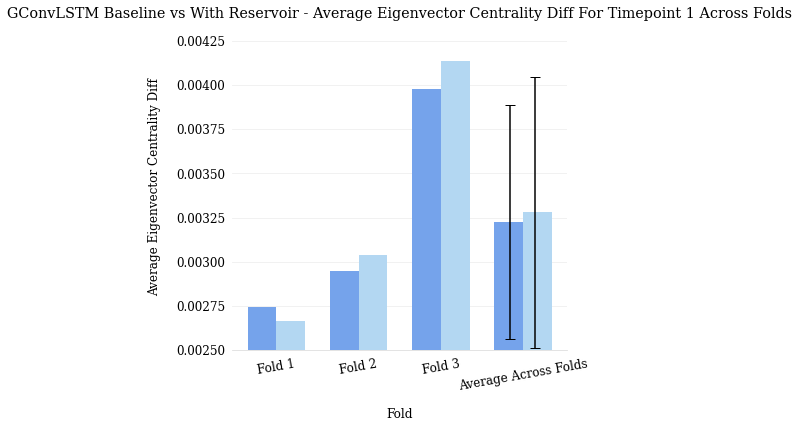

Mean: 0.004917250167386474
Standard Deviation 0.000460064212932709
Baseline Mean: 0.005076178750407504
Baseline Standard Deviation 0.0004303905874626173


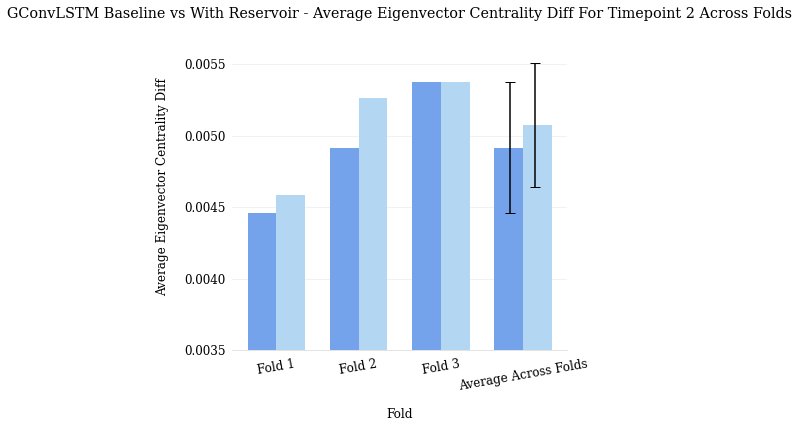

In [149]:
reservoir_eigenvector_centrality_diff = get_diffs_across_folds(eigenvector_centrality_diff, predicted_across_all_folds, original_across_all_folds)
baseline_eigenvector_centrality_diff = get_diffs_across_folds(eigenvector_centrality_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'GConvLSTM Baseline vs With Reservoir - Average Eigenvector Centrality Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_eigenvector_centrality_diff, baseline_eigenvector_centrality_diff, title, 'Average Eigenvector Centrality Diff', 0, (0.0025,), palette_nodewise)
title = 'GConvLSTM Baseline vs With Reservoir - Average Eigenvector Centrality Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_eigenvector_centrality_diff, baseline_eigenvector_centrality_diff, title, 'Average Eigenvector Centrality Diff', 1, (0.0035,), palette_nodewise)

### Efficiency

In [144]:
reservoir_global_efficiency_diff = get_diffs_across_folds(global_efficiency_diff, predicted_across_all_folds, original_across_all_folds)
baseline_global_efficiency_diff = get_diffs_across_folds(global_efficiency_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 0.062224092787674386
Standard Deviation 0.010255504944852724
Baseline Mean: 0.05870578413137808
Baseline Standard Deviation 0.007213093179978733


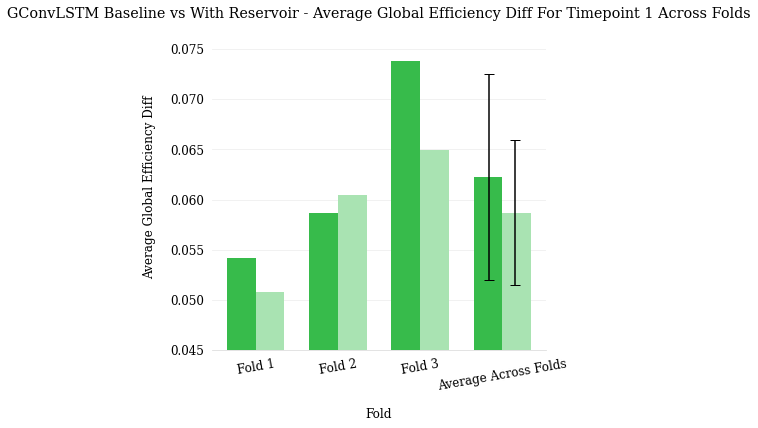

Mean: 0.07672968248487659
Standard Deviation 0.013105534725188066
Baseline Mean: 0.07408092039769357
Baseline Standard Deviation 0.01581048700046518


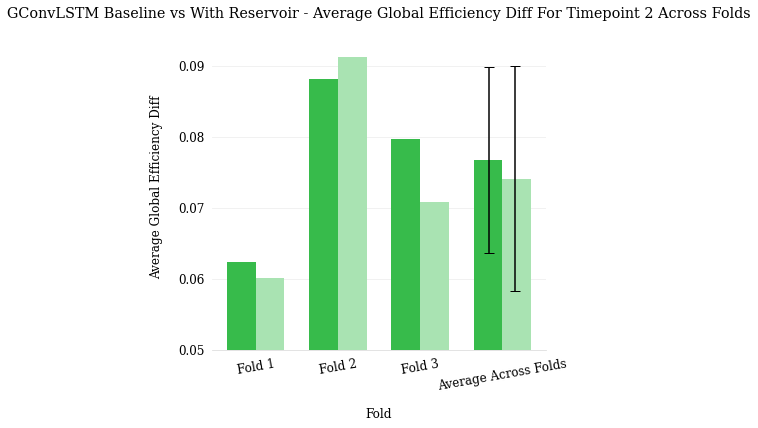

In [150]:
title = 'GConvLSTM Baseline vs With Reservoir - Average Global Efficiency Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_global_efficiency_diff, baseline_global_efficiency_diff, title, 'Average Global Efficiency Diff', 0, (0.045,), palette_efficiency)
title = 'GConvLSTM Baseline vs With Reservoir - Average Global Efficiency Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_global_efficiency_diff, baseline_global_efficiency_diff, title, 'Average Global Efficiency Diff', 1, (0.05,), palette_efficiency)

In [146]:
reservoir_local_efficiency_diff = get_diffs_across_folds(local_efficiency_diff, predicted_across_all_folds, original_across_all_folds)
baseline_local_efficiency_diff = get_diffs_across_folds(local_efficiency_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 0.013152409613854823
Standard Deviation 0.0017354210726717725
Baseline Mean: 0.012011916454656133
Baseline Standard Deviation 0.0021238210208929477


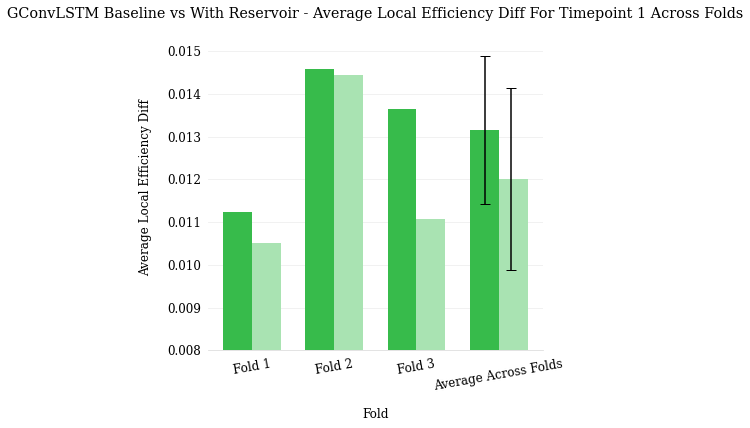

Mean: 0.017531648881063906
Standard Deviation 0.004375844495354639
Baseline Mean: 0.01683572611451077
Baseline Standard Deviation 0.0046957638933638425


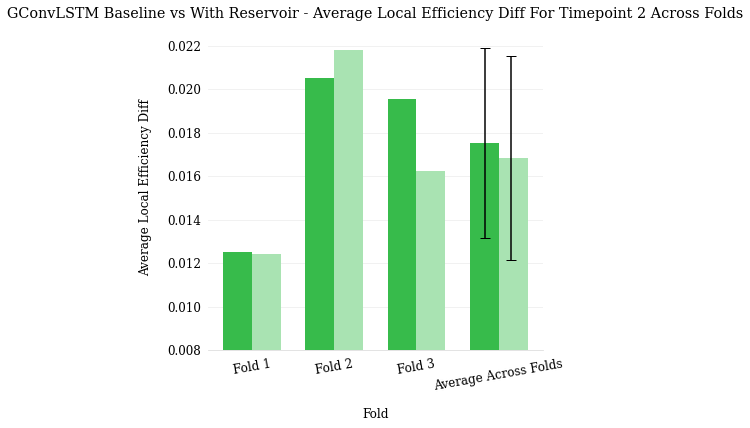

In [152]:
title = 'GConvLSTM Baseline vs With Reservoir - Average Local Efficiency Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_local_efficiency_diff, baseline_local_efficiency_diff, title, 'Average Local Efficiency Diff', 0, (0.008,), palette_efficiency)
title = 'GConvLSTM Baseline vs With Reservoir - Average Local Efficiency Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_local_efficiency_diff, baseline_local_efficiency_diff, title, 'Average Local Efficiency Diff', 1, (0.008,), palette_efficiency)

### Modularity

In [153]:
reservoir_modularity_diff = get_diffs_across_folds(modularity_diff, predicted_across_all_folds, original_across_all_folds)
baseline_modularity_diff = get_diffs_across_folds(modularity_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 0.003424715422691487
Standard Deviation 0.0006769428407362867
Baseline Mean: 0.0031475924628943676
Baseline Standard Deviation 0.0003519971882936698


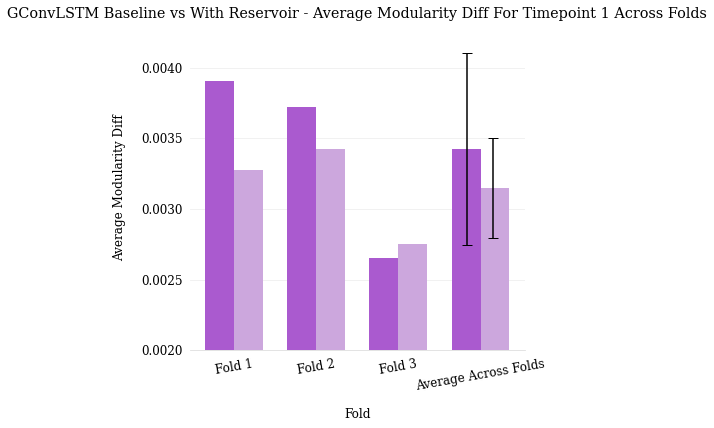

Mean: 0.0034793023878350034
Standard Deviation 0.0007607929121959917
Baseline Mean: 0.0032576032584717765
Baseline Standard Deviation 0.000981648005056382


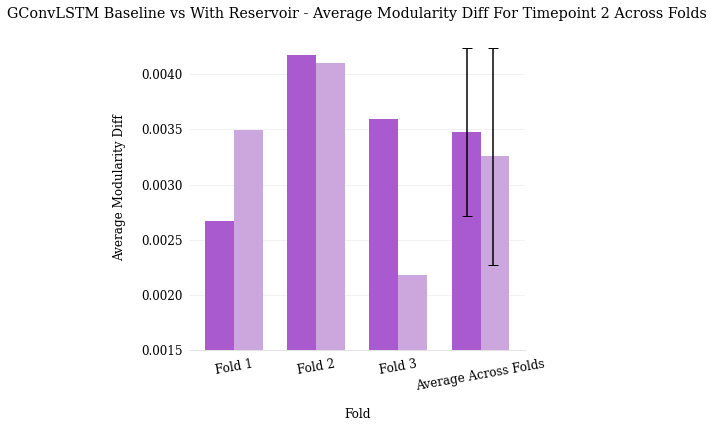

In [157]:
title = 'GConvLSTM Baseline vs With Reservoir - Average Modularity Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_modularity_diff, baseline_modularity_diff, title, 'Average Modularity Diff', 0, (0.002,), palette_global)
title = 'GConvLSTM Baseline vs With Reservoir - Average Modularity Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_modularity_diff, baseline_modularity_diff, title, 'Average Modularity Diff', 1, (0.0015,), palette_global)           

### Density

Mean: 0.025232795821031027
Standard Deviation 0.004011282797570357
Baseline Mean: 0.028755513585234913
Baseline Standard Deviation 0.018730286984136403


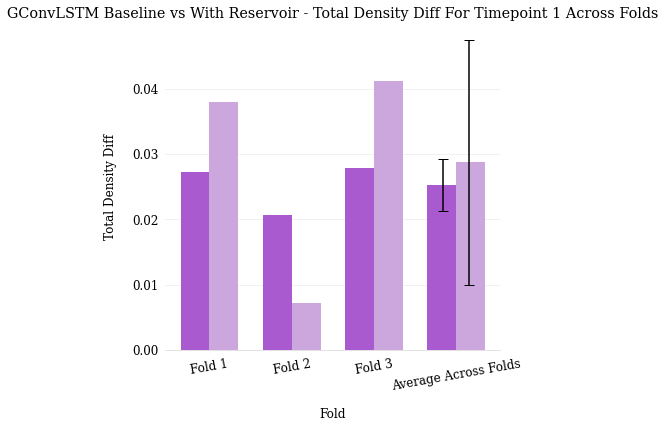

Mean: 0.029881141645847445
Standard Deviation 0.007220695278404612
Baseline Mean: 0.03232524873391746
Baseline Standard Deviation 0.02014309969377798


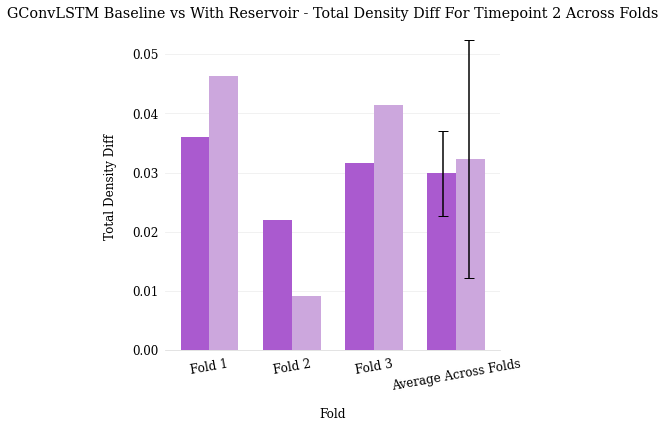

In [155]:
reservoir_density_diff = get_diffs_across_folds(density_diff, predicted_across_all_folds, original_across_all_folds)
baseline_density_diff = get_diffs_across_folds(density_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'GConvLSTM Baseline vs With Reservoir - Total Density Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_density_diff, baseline_density_diff, title, 'Total Density Diff', 0, (0,), palette_global)
title = 'GConvLSTM Baseline vs With Reservoir - Total Density Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_density_diff, baseline_density_diff, title, 'Total Density Diff', 1, (0,), palette_global)


### Clustering

Mean: 0.015318403289105173
Standard Deviation 0.0013497054070493563
Baseline Mean: 0.013239181667847027
Baseline Standard Deviation 0.0038105688171910365


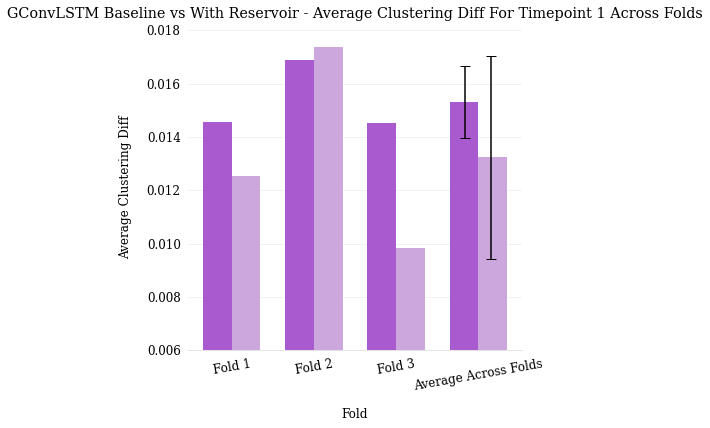

Mean: 0.018720923228144348
Standard Deviation 0.00389341297606798
Baseline Mean: 0.017393622666846464
Baseline Standard Deviation 0.005682839746749302


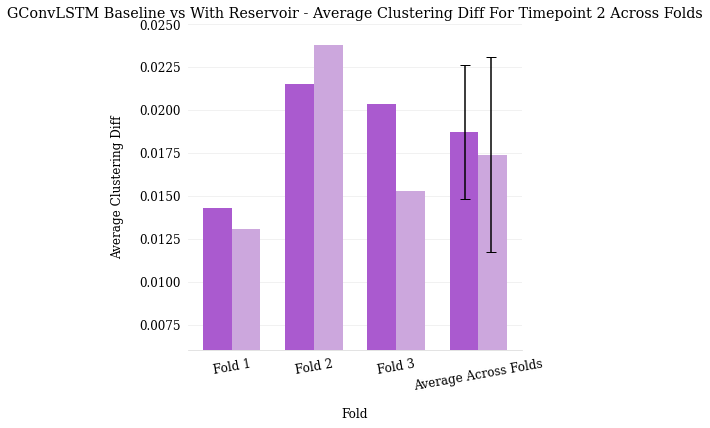

In [158]:
reservoir_clustering_diff = get_diffs_across_folds(clustering_diff, predicted_across_all_folds, original_across_all_folds)
baseline_clustering_diff = get_diffs_across_folds(clustering_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

title = 'GConvLSTM Baseline vs With Reservoir - Average Clustering Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_clustering_diff, baseline_clustering_diff, title, 'Average Clustering Diff', 0, (0.006,), palette_global)
title = 'GConvLSTM Baseline vs With Reservoir - Average Clustering Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_clustering_diff, baseline_clustering_diff, title, 'Average Clustering Diff', 1, (0.006,), palette_global)

## TAGConv

In [21]:
file_path = '/vol/bitbucket/sx420/4D-FedGNN-Plus/results/reservoir_tag_oasis_t/'
mae_across_all_folds, mem_cap_across_all_folds,\
predicted_across_all_folds, original_across_all_folds = load_test_results(file_path, 3, 38, 2)

In [22]:
baseline_file_path = '/vol/bitbucket/sx420/4D-FedGNN-Plus/results/baseline_tag_oasis_t/'
baseline_mae_across_all_folds, baseline_mem_cap_across_all_folds,\
baseline_predicted_across_all_folds, baseline_original_across_all_folds = load_test_results(baseline_file_path, 3, 38, 2)

Mean: 0.0395463645147339
Standard Deviation 0.0028617382778230774
Baseline Mean: 0.0399529939864472
Baseline Standard Deviation 0.003143842658706076


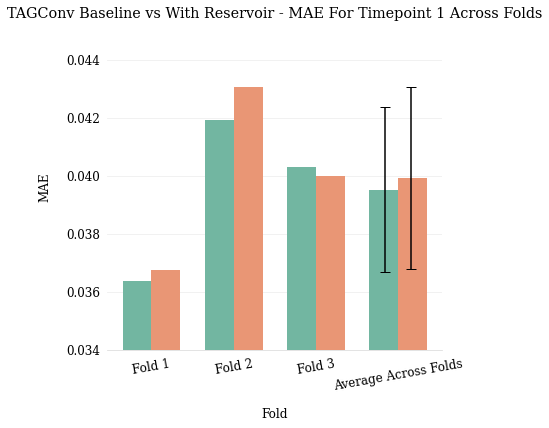

In [75]:
title = 'TAGConv Baseline vs With Reservoir - MAE For Timepoint 1 Across Folds'
plot_comparison(mae_across_all_folds, baseline_mae_across_all_folds, title, 'MAE', 0, (0.034,))

Mean: 0.04371068804339811
Standard Deviation 0.0021036958052130135
Baseline Mean: 0.044423836506390924
Baseline Standard Deviation 0.0024842635090355563


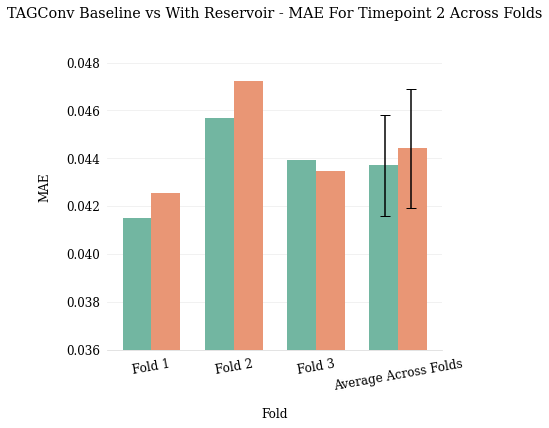

In [74]:
title = 'TAGConv Baseline vs With Reservoir - MAE For Timepoint 2 Across Folds'
plot_comparison(mae_across_all_folds, baseline_mae_across_all_folds, title, 'MAE', 1, (0.036, ))

Mean: 0.7129401479626903
Standard Deviation 0.08011794778612849
Baseline Mean: 0.7914189159671647
Baseline Standard Deviation 0.08322787053409836


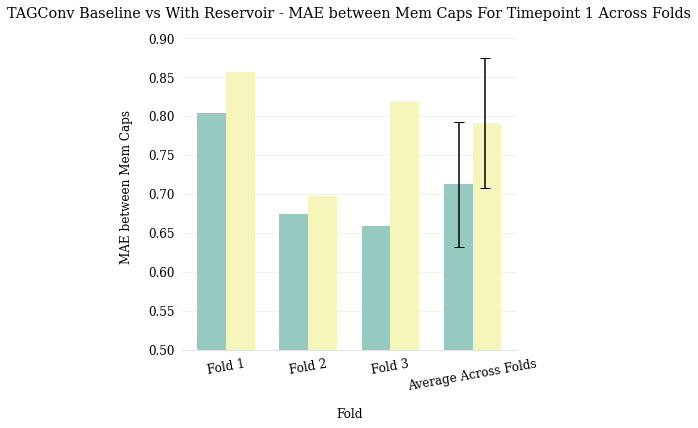

In [78]:
title = 'TAGConv Baseline vs With Reservoir - MAE between Mem Caps For Timepoint 1 Across Folds'
plot_comparison(mem_cap_across_all_folds, baseline_mem_cap_across_all_folds, title, 'MAE between Mem Caps', 0, (0.5,), 'Set3')

Mean: 0.8077650204990716
Standard Deviation 0.054213220598734645
Baseline Mean: 0.998299252434967
Baseline Standard Deviation 0.14526498052283526


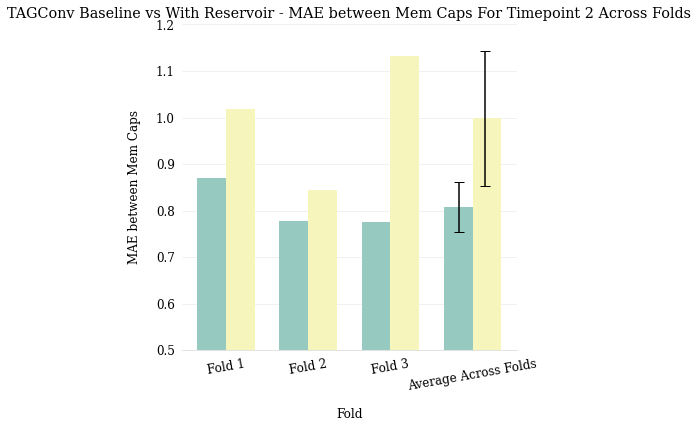

In [79]:
title = 'TAGConv Baseline vs With Reservoir - MAE between Mem Caps For Timepoint 2 Across Folds'
plot_comparison(mem_cap_across_all_folds, baseline_mem_cap_across_all_folds, title, 'MAE between Mem Caps', 1, (0.5,), 'Set3')

In [72]:
baseline_tag_times = [194.15, 195.89, 199.85]
baseline_tag_memory_usage_MB = [2100.30, 2097.74, 2095.66]

In [73]:
reservoir_tag_times = [977.26, 972.30, 1092.41]
reservoir_tag_memory_usage_MB = [2119.45, 2121.70, 2120.31]

In [74]:
print_mean_std(reservoir_tag_times, baseline_tag_times)

Mean: 1013.99
Standard Deviation 67.95897806765497
Baseline Mean: 196.63
Baseline Standard Deviation 2.9211641514985045


(1013.99, 196.63, 67.95897806765497, 2.9211641514985045)

In [75]:
print_mean_std(reservoir_tag_memory_usage_MB, baseline_tag_memory_usage_MB)

Mean: 2120.4866666666667
Standard Deviation 1.1353560381366326
Baseline Mean: 2097.9
Baseline Standard Deviation 2.3241342474136037


(2120.4866666666667, 2097.9, 1.1353560381366326, 2.3241342474136037)

### Node Strength

Mean: 0.40678674043792157
Standard Deviation 0.09597963878361493
Baseline Mean: 0.42976448700617137
Baseline Standard Deviation 0.12210246476184215


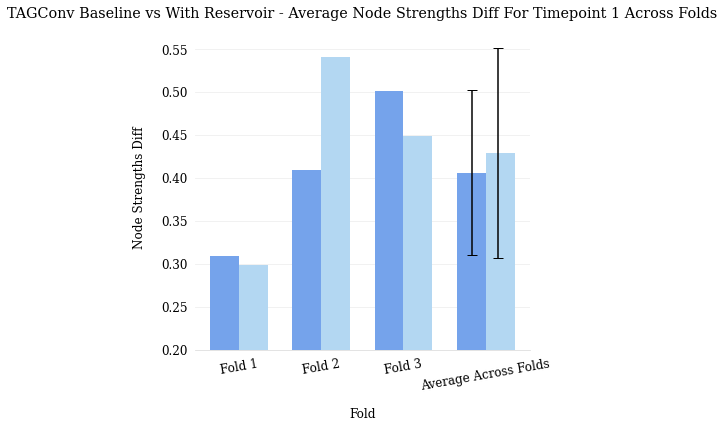

Mean: 0.5293600982489352
Standard Deviation 0.11804036296042954
Baseline Mean: 0.6094105116507005
Baseline Standard Deviation 0.18459220699241516


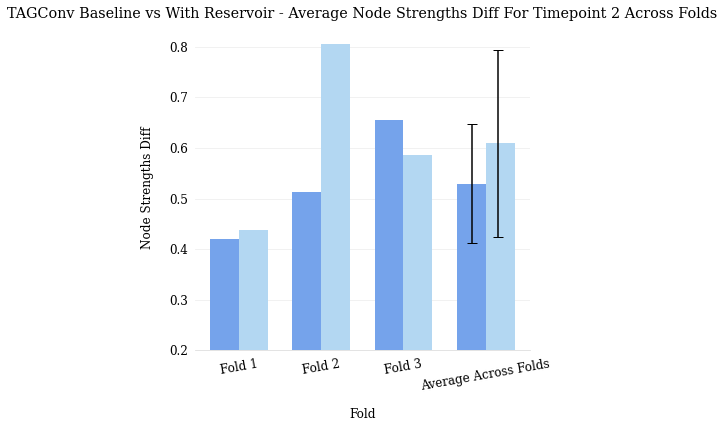

In [37]:
reservoir_node_strength_diff = get_diffs_across_folds(node_strength_diff, predicted_across_all_folds, original_across_all_folds)
baseline_node_strength_diff = get_diffs_across_folds(node_strength_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'TAGConv Baseline vs With Reservoir - Average Node Strengths Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_node_strength_diff, baseline_node_strength_diff, title, 'Node Strengths Diff', 0, (0.2,), palette_nodewise)
title = 'TAGConv Baseline vs With Reservoir - Average Node Strengths Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_node_strength_diff, baseline_node_strength_diff, title, 'Node Strengths Diff', 1, (0.2,), palette_nodewise)

### Centrality

Mean: 0.007919104672824842
Standard Deviation 0.00024383199934805837
Baseline Mean: 0.007599853422992916
Baseline Standard Deviation 0.0015715850555169627


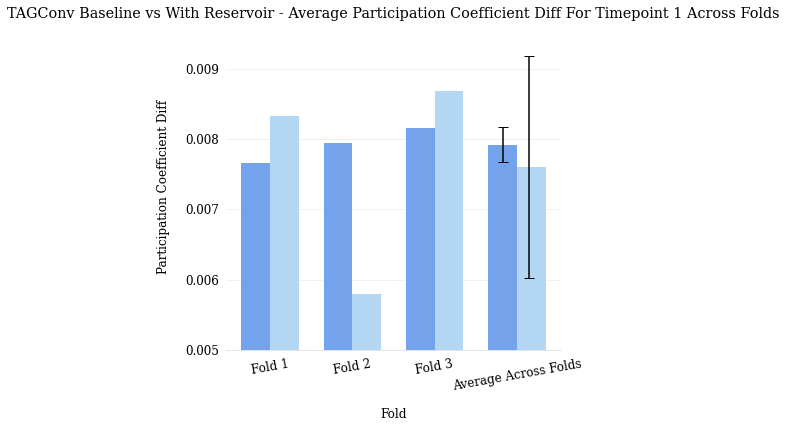

Mean: 0.009564660772955896
Standard Deviation 0.0016886173851075894
Baseline Mean: 0.009115872694786526
Baseline Standard Deviation 0.0012872728051799445


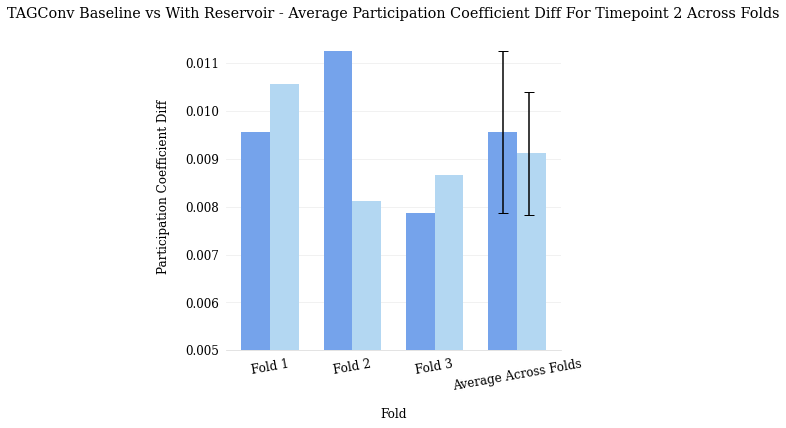

In [24]:
reservoir_participation_coef_diff = get_diffs_across_folds(participation_coef_diff, predicted_across_all_folds, original_across_all_folds)
baseline_participation_coef_diff = get_diffs_across_folds(participation_coef_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'TAGConv Baseline vs With Reservoir - Average Participation Coefficient Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_participation_coef_diff, baseline_participation_coef_diff, title, 'Participation Coefficient Diff', 0, (0.005,), palette_nodewise)
title = 'TAGConv Baseline vs With Reservoir - Average Participation Coefficient Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_participation_coef_diff, baseline_participation_coef_diff, title, 'Participation Coefficient Diff', 1, (0.005,), palette_nodewise)

Mean: 0.04049129769744141
Standard Deviation 0.002169928818483443
Baseline Mean: 0.03804153690004348
Baseline Standard Deviation 0.008373722689295133


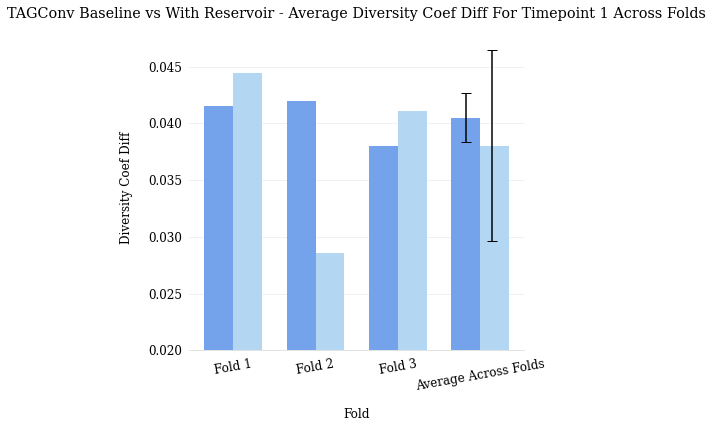

Mean: 0.046297627884952064
Standard Deviation 0.006454962025946865
Baseline Mean: 0.043467212904012564
Baseline Standard Deviation 0.010002698522378175


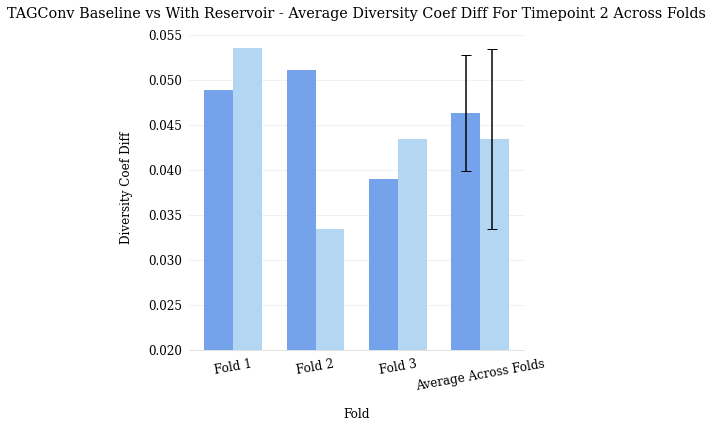

In [25]:
reservoir_diversity_coef_diff = get_diffs_across_folds(diversity_coef_diff, predicted_across_all_folds, original_across_all_folds)
baseline_diversity_coef_diff = get_diffs_across_folds(diversity_coef_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'TAGConv Baseline vs With Reservoir - Average Diversity Coef Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_diversity_coef_diff, baseline_diversity_coef_diff, title, 'Diversity Coef Diff', 0, (0.02,), palette_nodewise)
title = 'TAGConv Baseline vs With Reservoir - Average Diversity Coef Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_diversity_coef_diff, baseline_diversity_coef_diff, title, 'Diversity Coef Diff', 1, (0.02,), palette_nodewise)

In [26]:
reservoir_betweeness_centrality_diff = get_diffs_across_folds(betweeness_centrality_diff, predicted_across_all_folds, original_across_all_folds)
baseline_betweeness_centrality_diff = get_diffs_across_folds(betweeness_centrality_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 74.94072362177626
Standard Deviation 2.577843647620579
Baseline Mean: 75.55603216340056
Baseline Standard Deviation 2.4320824741907927


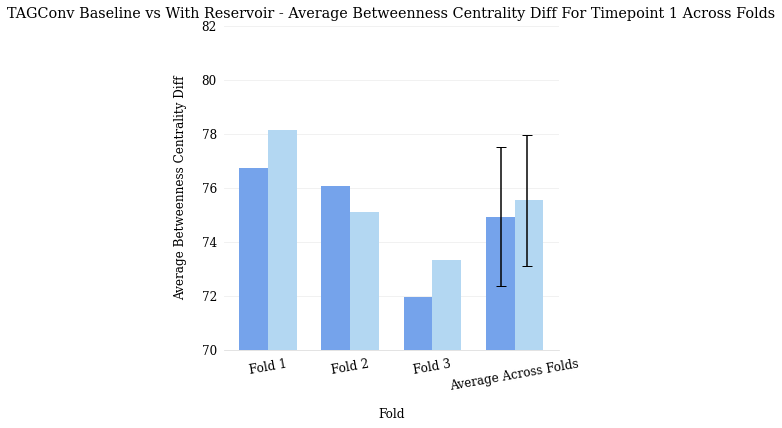

Mean: 80.79447931861465
Standard Deviation 3.2162046950047607
Baseline Mean: 81.2472057292358
Baseline Standard Deviation 4.892676661125214


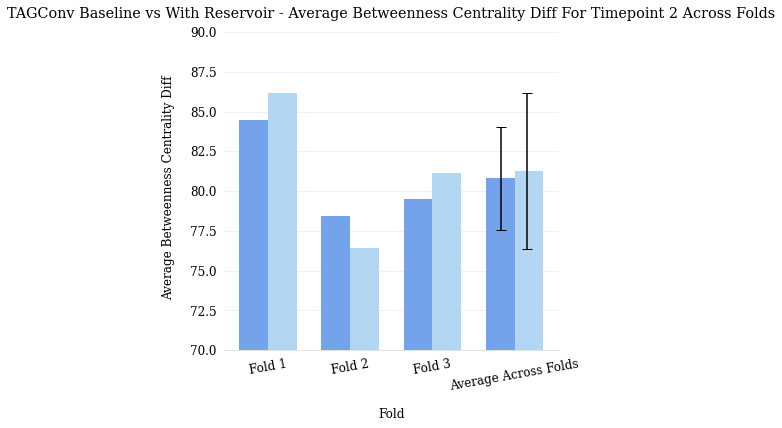

In [38]:
title = 'TAGConv Baseline vs With Reservoir - Average Betweenness Centrality Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_betweeness_centrality_diff, baseline_betweeness_centrality_diff, title, 'Average Betweenness Centrality Diff', 0, (70,), palette_nodewise)
title = 'TAGConv Baseline vs With Reservoir - Average Betweenness Centrality Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_betweeness_centrality_diff, baseline_betweeness_centrality_diff, title, 'Average Betweenness Centrality Diff', 1, (70,), palette_nodewise)

Mean: 0.0033858044761313944
Standard Deviation 0.0004972234308114235
Baseline Mean: 0.003249870271566291
Baseline Standard Deviation 0.0006644170984797524


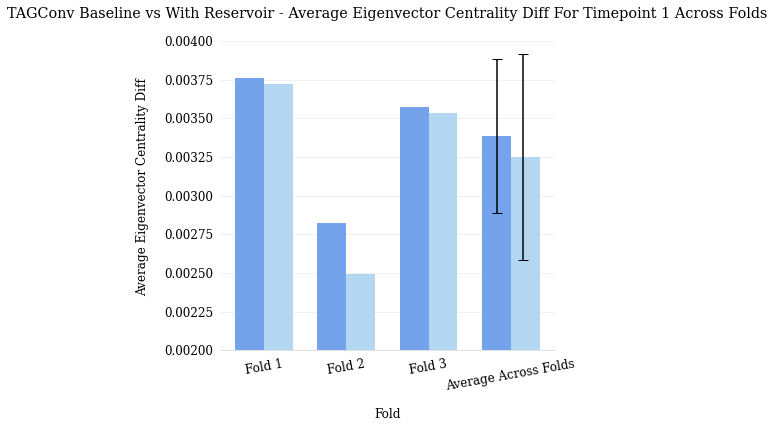

Mean: 0.005259131565201365
Standard Deviation 0.00040079142636536826
Baseline Mean: 0.005134514113654397
Baseline Standard Deviation 0.0005747821434052354


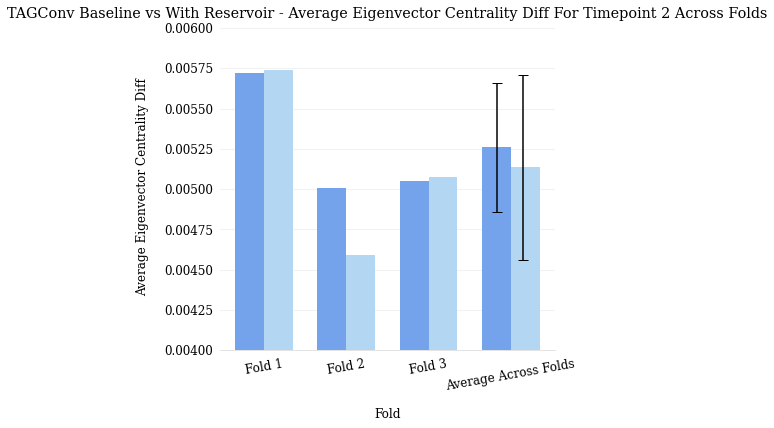

In [40]:
reservoir_eigenvector_centrality_diff = get_diffs_across_folds(eigenvector_centrality_diff, predicted_across_all_folds, original_across_all_folds)
baseline_eigenvector_centrality_diff = get_diffs_across_folds(eigenvector_centrality_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'TAGConv Baseline vs With Reservoir - Average Eigenvector Centrality Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_eigenvector_centrality_diff, baseline_eigenvector_centrality_diff, title, 'Average Eigenvector Centrality Diff', 0, (0.0020,), palette_nodewise)
title = 'TAGConv Baseline vs With Reservoir - Average Eigenvector Centrality Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_eigenvector_centrality_diff, baseline_eigenvector_centrality_diff, title, 'Average Eigenvector Centrality Diff', 1, (0.004,), palette_nodewise)

### Efficiency

In [29]:
reservoir_global_efficiency_diff = get_diffs_across_folds(global_efficiency_diff, predicted_across_all_folds, original_across_all_folds)
baseline_global_efficiency_diff = get_diffs_across_folds(global_efficiency_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 0.03993537128549325
Standard Deviation 0.01211790009430486
Baseline Mean: 0.041393943844835225
Baseline Standard Deviation 0.011168619466179018


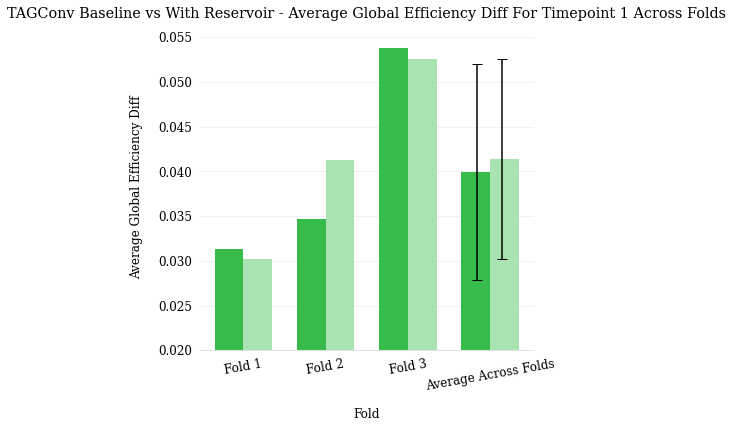

Mean: 0.055285032245955976
Standard Deviation 0.010598967024962347
Baseline Mean: 0.05727580229575958
Baseline Standard Deviation 0.016463538105719967


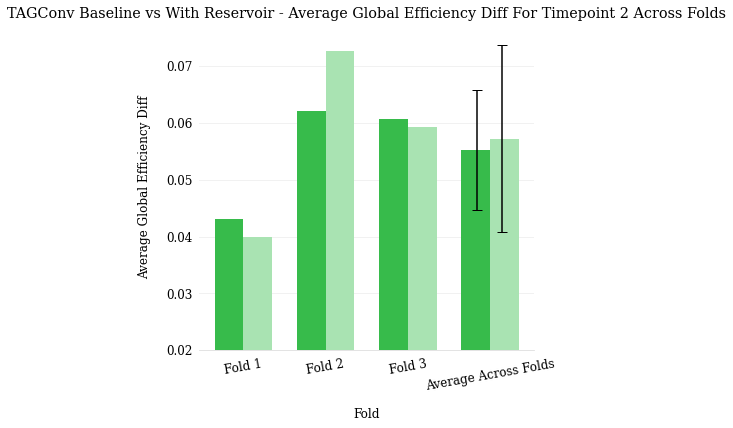

In [30]:
title = 'TAGConv Baseline vs With Reservoir - Average Global Efficiency Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_global_efficiency_diff, baseline_global_efficiency_diff, title, 'Average Global Efficiency Diff', 0, (0.02,), palette_efficiency)
title = 'TAGConv Baseline vs With Reservoir - Average Global Efficiency Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_global_efficiency_diff, baseline_global_efficiency_diff, title, 'Average Global Efficiency Diff', 1, (0.02,), palette_efficiency)

In [31]:
reservoir_local_efficiency_diff = get_diffs_across_folds(local_efficiency_diff, predicted_across_all_folds, original_across_all_folds)
baseline_local_efficiency_diff = get_diffs_across_folds(local_efficiency_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 0.009624807341670292
Standard Deviation 0.0016010104631116492
Baseline Mean: 0.010102209901097604
Baseline Standard Deviation 0.0015651798751277987


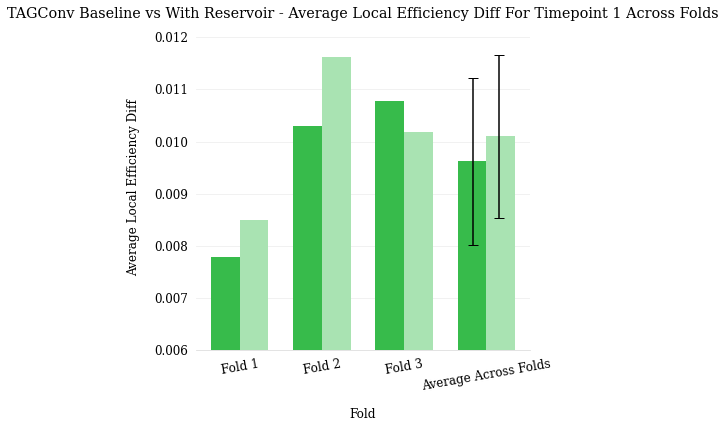

Mean: 0.012759477980399043
Standard Deviation 0.0015434365704495713
Baseline Mean: 0.01432447957688107
Baseline Standard Deviation 0.0021039602139260177


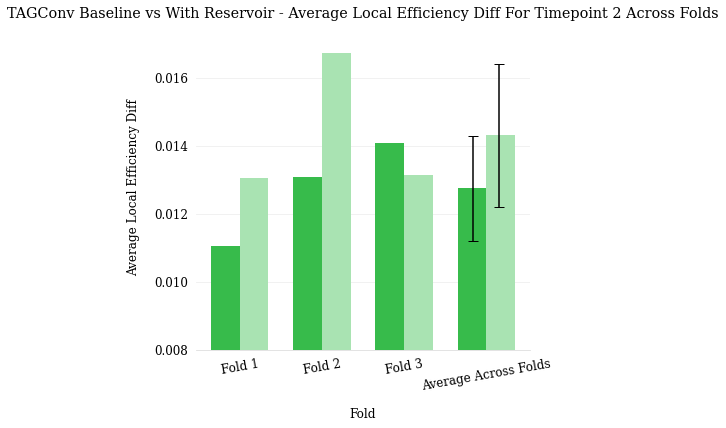

In [32]:
title = 'TAGConv Baseline vs With Reservoir - Average Local Efficiency Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_local_efficiency_diff, baseline_local_efficiency_diff, title, 'Average Local Efficiency Diff', 0, (0.006,), palette_efficiency)
title = 'TAGConv Baseline vs With Reservoir - Average Local Efficiency Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_local_efficiency_diff, baseline_local_efficiency_diff, title, 'Average Local Efficiency Diff', 1, (0.008,), palette_efficiency)

### Modularity

In [33]:
reservoir_modularity_diff = get_diffs_across_folds(modularity_diff, predicted_across_all_folds, original_across_all_folds)
baseline_modularity_diff = get_diffs_across_folds(modularity_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 0.0032174329564688578
Standard Deviation 0.00010969383824774808
Baseline Mean: 0.003308086902459262
Baseline Standard Deviation 0.0009651926931584649


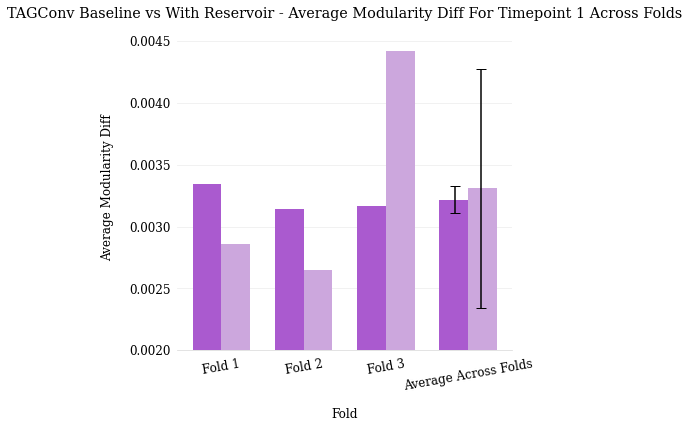

Mean: 0.0039027632179183674
Standard Deviation 0.0009968208241052574
Baseline Mean: 0.0033239917940061105
Baseline Standard Deviation 0.0006623477589432051


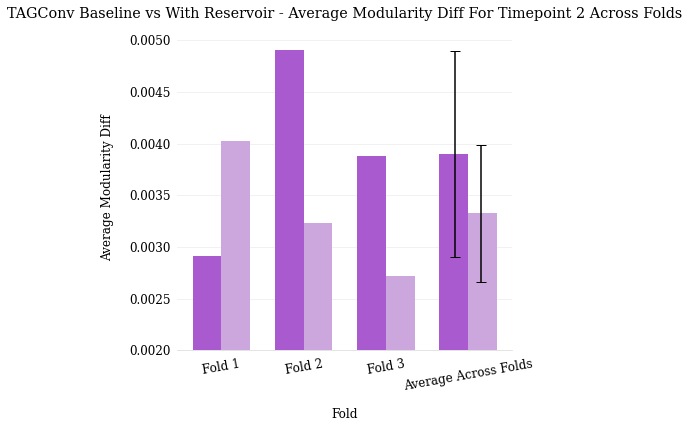

In [41]:
title = 'TAGConv Baseline vs With Reservoir - Average Modularity Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_modularity_diff, baseline_modularity_diff, title, 'Average Modularity Diff', 0, (0.002,), palette_global)
title = 'TAGConv Baseline vs With Reservoir - Average Modularity Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_modularity_diff, baseline_modularity_diff, title, 'Average Modularity Diff', 1, (0.002,), palette_global)           

### Density

Mean: 0.060016495929808615
Standard Deviation 0.005534821147268918
Baseline Mean: 0.06166090902933006
Baseline Standard Deviation 0.007262032812095161


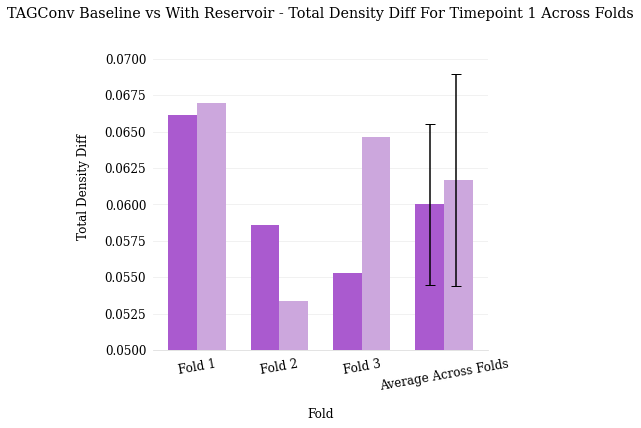

Mean: 0.06008184212518577
Standard Deviation 0.00669351853516266
Baseline Mean: 0.062225117643074285
Baseline Standard Deviation 0.007645657765891131


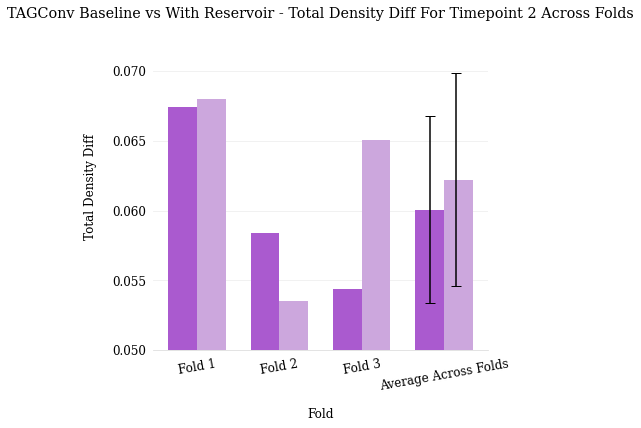

In [42]:
reservoir_density_diff = get_diffs_across_folds(density_diff, predicted_across_all_folds, original_across_all_folds)
baseline_density_diff = get_diffs_across_folds(density_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'TAGConv Baseline vs With Reservoir - Total Density Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_density_diff, baseline_density_diff, title, 'Total Density Diff', 0, (0.05,), palette_global)
title = 'TAGConv Baseline vs With Reservoir - Total Density Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_density_diff, baseline_density_diff, title, 'Total Density Diff', 1, (0.05,), palette_global)


### Clustering

Mean: 0.009763502865026379
Standard Deviation 0.0014937144590677904
Baseline Mean: 0.009825287499082706
Baseline Standard Deviation 0.0010536543257198595


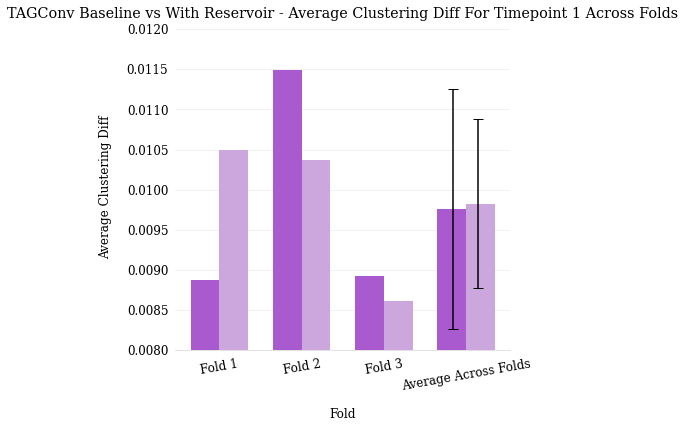

Mean: 0.012572163158301832
Standard Deviation 0.0008360278259263773
Baseline Mean: 0.013740323258347365
Baseline Standard Deviation 0.002600698825936703


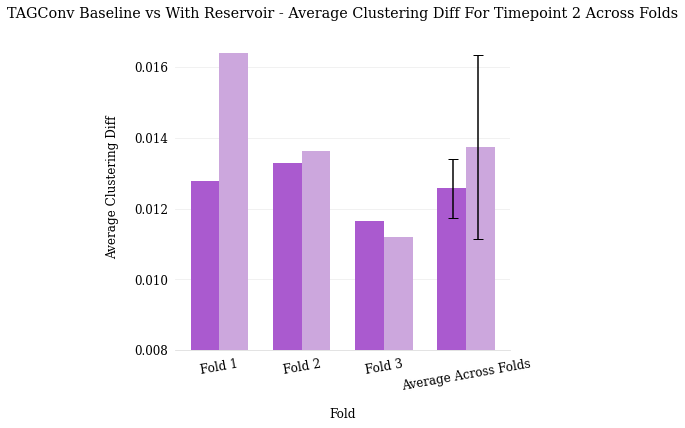

In [43]:
reservoir_clustering_diff = get_diffs_across_folds(clustering_diff, predicted_across_all_folds, original_across_all_folds)
baseline_clustering_diff = get_diffs_across_folds(clustering_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

title = 'TAGConv Baseline vs With Reservoir - Average Clustering Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_clustering_diff, baseline_clustering_diff, title, 'Average Clustering Diff', 0, (0.008,), palette_global)
title = 'TAGConv Baseline vs With Reservoir - Average Clustering Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_clustering_diff, baseline_clustering_diff, title, 'Average Clustering Diff', 1, (0.008,), palette_global)

## RBGM

In [44]:
file_path = '/vol/bitbucket/sx420/4D-FedGNN-Plus/results/reservoir_rbgm_oasis_t1/'
mae_across_all_folds, mem_cap_across_all_folds,\
predicted_across_all_folds, original_across_all_folds = load_test_results(file_path, 3, 38, 2)

In [45]:
baseline_file_path = '/vol/bitbucket/sx420/4D-FedGNN-Plus/results/baseline_rbgm_oasis_t1/'
baseline_mae_across_all_folds, baseline_mem_cap_across_all_folds,\
baseline_predicted_across_all_folds, baseline_original_across_all_folds = load_test_results(baseline_file_path, 3, 38, 2)

Mean: 0.04420518080958714
Standard Deviation 0.00422654782718911
Baseline Mean: 0.04426312025489825
Baseline Standard Deviation 0.004187473880720704


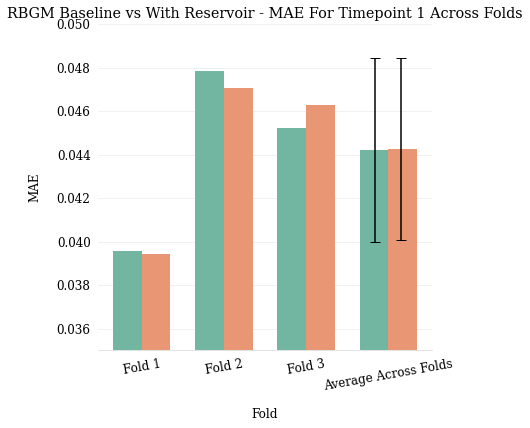

In [95]:
title = 'RBGM Baseline vs With Reservoir - MAE For Timepoint 1 Across Folds'
plot_comparison(mae_across_all_folds, baseline_mae_across_all_folds, title, 'MAE', 0, (0.035,0.05))

Mean: 0.054457645695488735
Standard Deviation 0.005662062934877343
Baseline Mean: 0.052016182271379496
Baseline Standard Deviation 0.004642421328062717


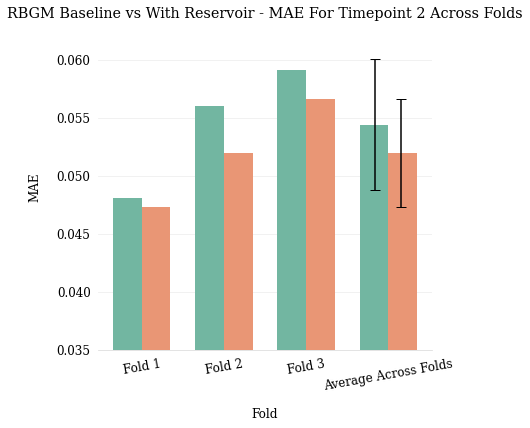

In [96]:
title = 'RBGM Baseline vs With Reservoir - MAE For Timepoint 2 Across Folds'
plot_comparison(mae_across_all_folds, baseline_mae_across_all_folds, title, 'MAE', 1, (0.035,))

Mean: 0.2902027863922589
Standard Deviation 0.023929736368402423
Baseline Mean: 0.37885273861362356
Baseline Standard Deviation 0.031103988168483393


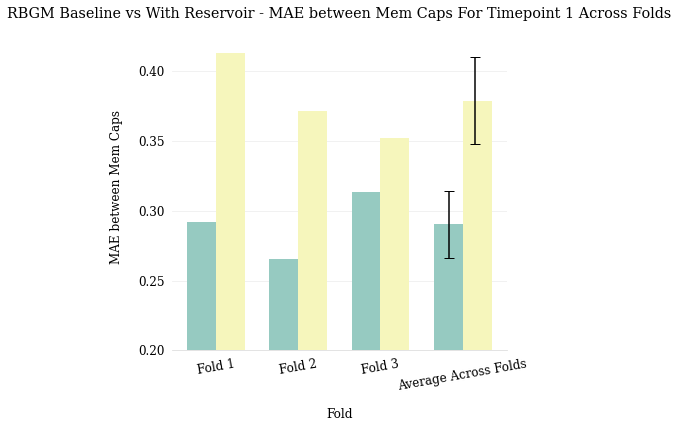

In [101]:
title = 'RBGM Baseline vs With Reservoir - MAE between Mem Caps For Timepoint 1 Across Folds'
plot_comparison(mem_cap_across_all_folds, baseline_mem_cap_across_all_folds, title, 'MAE between Mem Caps', 0, (0.2,), 'Set3')

Mean: 0.37026051264102267
Standard Deviation 0.02485969946235538
Baseline Mean: 0.3959363017273632
Baseline Standard Deviation 0.1167723975247782


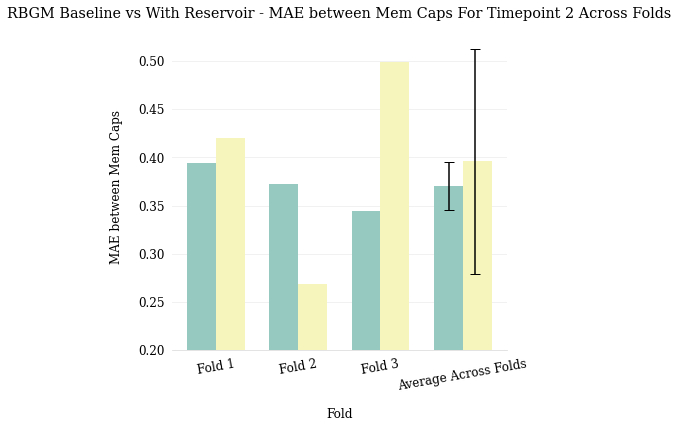

In [102]:
title = 'RBGM Baseline vs With Reservoir - MAE between Mem Caps For Timepoint 2 Across Folds'
plot_comparison(mem_cap_across_all_folds, baseline_mem_cap_across_all_folds, title, 'MAE between Mem Caps', 1, (0.2,), 'Set3')

In [106]:
baseline_rbgm_times = [192.66, 193.89, 199.58]
baseline_rbgm_memory_usage_MB = [2601.66, 2601.66, 2601.66]

In [107]:
reservoir_rbgm_times = [1322.42, 1138.16, 1129.35]
reservoir_rbgm_memory_usage_MB = [2641.55, 2641.55, 2641.55]

In [108]:
print_mean_std(reservoir_rbgm_times, baseline_rbgm_times)

Mean: 1196.6433333333334
Standard Deviation 109.01482208091404
Baseline Mean: 195.37666666666667
Baseline Standard Deviation 3.691779155547284


(1196.6433333333334, 195.37666666666667, 109.01482208091404, 3.691779155547284)

In [109]:
print_mean_std(reservoir_rbgm_memory_usage_MB, baseline_rbgm_memory_usage_MB)

Mean: 2641.55
Standard Deviation 0.0
Baseline Mean: 2601.66
Baseline Standard Deviation 0.0


(2641.55, 2601.66, 0.0, 0.0)

### Node Strength

Mean: 0.5968459159360613
Standard Deviation 0.130879643558822
Baseline Mean: 0.572013103818495
Baseline Standard Deviation 0.1564174398081938


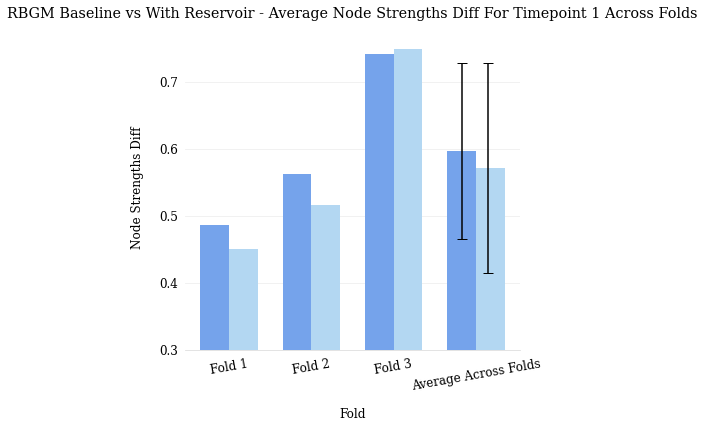

Mean: 1.155752746003585
Standard Deviation 0.4412707401652778
Baseline Mean: 1.0142494335562593
Baseline Standard Deviation 0.3407493288649637


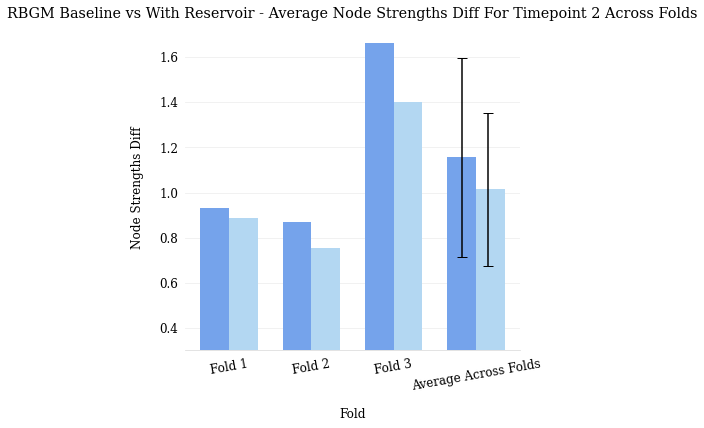

In [60]:
reservoir_node_strength_diff = get_diffs_across_folds(node_strength_diff, predicted_across_all_folds, original_across_all_folds)
baseline_node_strength_diff = get_diffs_across_folds(node_strength_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'RBGM Baseline vs With Reservoir - Average Node Strengths Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_node_strength_diff, baseline_node_strength_diff, title, 'Node Strengths Diff', 0, (0.3,), palette_nodewise)
title = 'RBGM Baseline vs With Reservoir - Average Node Strengths Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_node_strength_diff, baseline_node_strength_diff, title, 'Node Strengths Diff', 1, (0.3,), palette_nodewise)

### Centrality

Mean: 0.0029673094092967757
Standard Deviation 0.0007683820666897743
Baseline Mean: 0.0035776528993947594
Baseline Standard Deviation 0.0006000140882155473


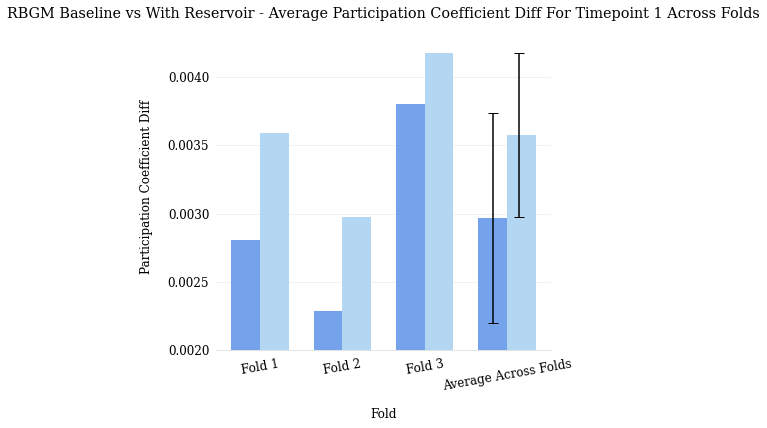

Mean: 0.007546973255762869
Standard Deviation 0.003607886644948784
Baseline Mean: 0.0077736338625604955
Baseline Standard Deviation 0.005049816145303454


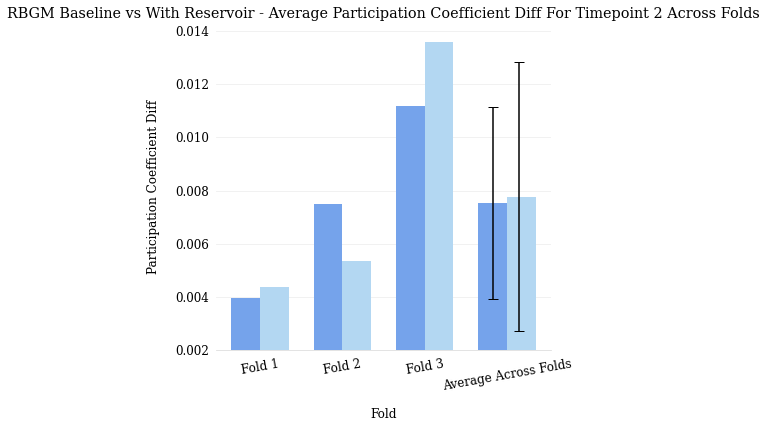

In [47]:
reservoir_participation_coef_diff = get_diffs_across_folds(participation_coef_diff, predicted_across_all_folds, original_across_all_folds)
baseline_participation_coef_diff = get_diffs_across_folds(participation_coef_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'RBGM Baseline vs With Reservoir - Average Participation Coefficient Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_participation_coef_diff, baseline_participation_coef_diff, title, 'Participation Coefficient Diff', 0, (0.002,), palette_nodewise)
title = 'RBGM Baseline vs With Reservoir - Average Participation Coefficient Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_participation_coef_diff, baseline_participation_coef_diff, title, 'Participation Coefficient Diff', 1, (0.002,), palette_nodewise)

Mean: 0.011913291604072021
Standard Deviation 0.0023679854306890716
Baseline Mean: 0.015821344490222353
Baseline Standard Deviation 0.0027975944059796995


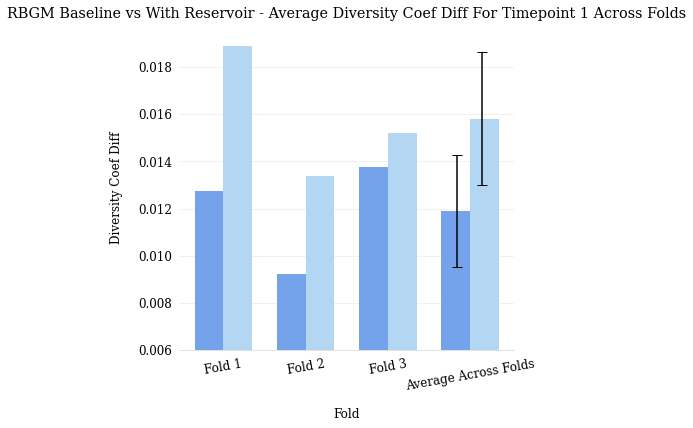

Mean: 0.03739251474758822
Standard Deviation 0.0221604352111869
Baseline Mean: 0.03545341299135837
Baseline Standard Deviation 0.025550468800244884


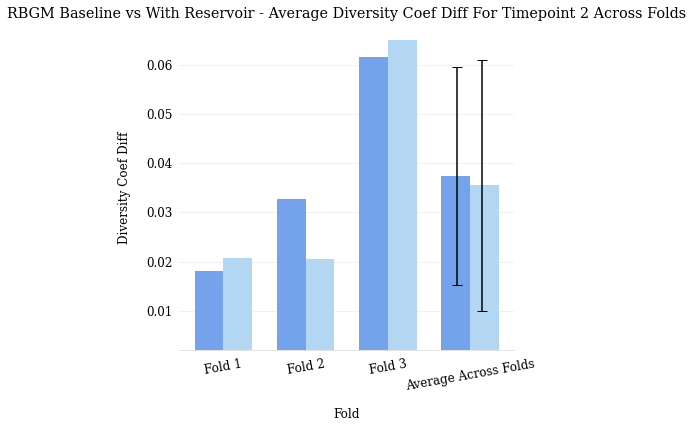

In [61]:
reservoir_diversity_coef_diff = get_diffs_across_folds(diversity_coef_diff, predicted_across_all_folds, original_across_all_folds)
baseline_diversity_coef_diff = get_diffs_across_folds(diversity_coef_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'RBGM Baseline vs With Reservoir - Average Diversity Coef Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_diversity_coef_diff, baseline_diversity_coef_diff, title, 'Diversity Coef Diff', 0, (0.006,), palette_nodewise)
title = 'RBGM Baseline vs With Reservoir - Average Diversity Coef Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_diversity_coef_diff, baseline_diversity_coef_diff, title, 'Diversity Coef Diff', 1, (0.002,), palette_nodewise)

In [49]:
reservoir_betweeness_centrality_diff = get_diffs_across_folds(betweeness_centrality_diff, predicted_across_all_folds, original_across_all_folds)
baseline_betweeness_centrality_diff = get_diffs_across_folds(betweeness_centrality_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 59.37174035279299
Standard Deviation 1.7737616828546667
Baseline Mean: 59.216690566164246
Baseline Standard Deviation 1.4269651470628217


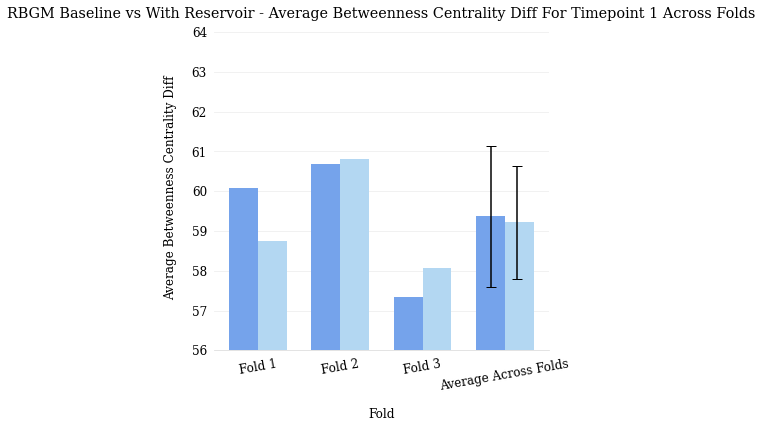

Mean: 55.76567758454977
Standard Deviation 0.5690654044955924
Baseline Mean: 55.01671057242486
Baseline Standard Deviation 2.733659478678578


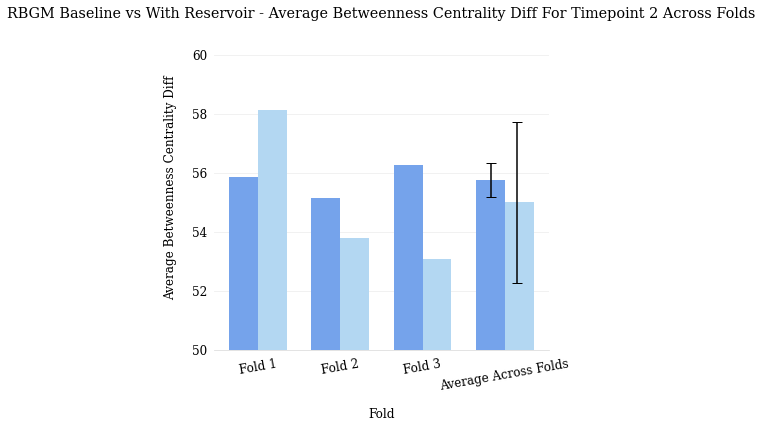

In [62]:
title = 'RBGM Baseline vs With Reservoir - Average Betweenness Centrality Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_betweeness_centrality_diff, baseline_betweeness_centrality_diff, title, 'Average Betweenness Centrality Diff', 0, (56,), palette_nodewise)
title = 'RBGM Baseline vs With Reservoir - Average Betweenness Centrality Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_betweeness_centrality_diff, baseline_betweeness_centrality_diff, title, 'Average Betweenness Centrality Diff', 1, (50,), palette_nodewise)

Mean: 0.0040506377383287525
Standard Deviation 0.0004373184937559513
Baseline Mean: 0.003968935208648504
Baseline Standard Deviation 0.00018728840417030484


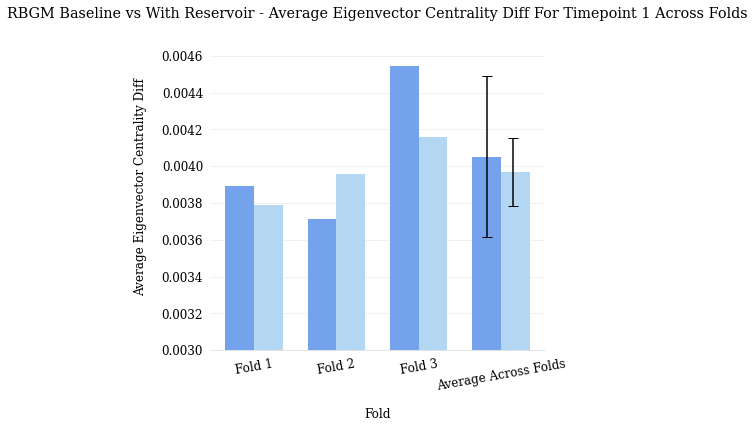

Mean: 0.004441341848565411
Standard Deviation 0.00042373141046573264
Baseline Mean: 0.004570559719942328
Baseline Standard Deviation 0.00048085811524601886


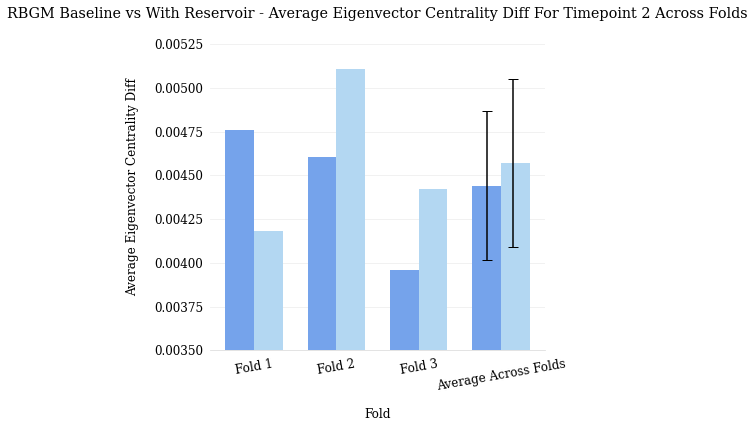

In [63]:
reservoir_eigenvector_centrality_diff = get_diffs_across_folds(eigenvector_centrality_diff, predicted_across_all_folds, original_across_all_folds)
baseline_eigenvector_centrality_diff = get_diffs_across_folds(eigenvector_centrality_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'RBGM Baseline vs With Reservoir - Average Eigenvector Centrality Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_eigenvector_centrality_diff, baseline_eigenvector_centrality_diff, title, 'Average Eigenvector Centrality Diff', 0, (0.003,), palette_nodewise)
title = 'RBGM Baseline vs With Reservoir - Average Eigenvector Centrality Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_eigenvector_centrality_diff, baseline_eigenvector_centrality_diff, title, 'Average Eigenvector Centrality Diff', 1, (0.0035,), palette_nodewise)

### Efficiency

In [52]:
reservoir_global_efficiency_diff = get_diffs_across_folds(global_efficiency_diff, predicted_across_all_folds, original_across_all_folds)
baseline_global_efficiency_diff = get_diffs_across_folds(global_efficiency_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 0.04442441315105507
Standard Deviation 0.01372899070756198
Baseline Mean: 0.04201492805766116
Baseline Standard Deviation 0.015474349416142884


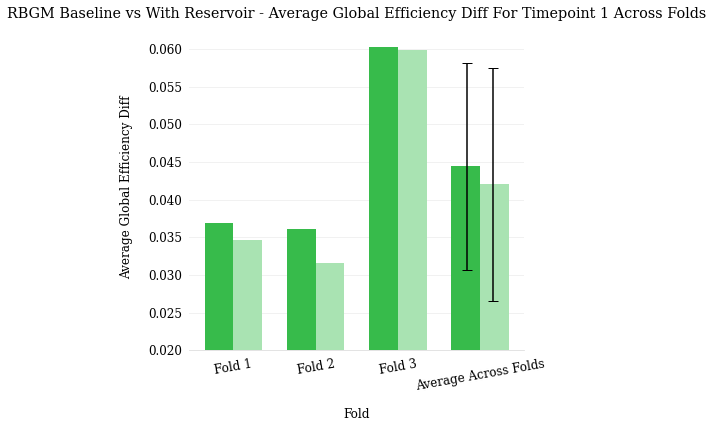

Mean: 0.07035722690645502
Standard Deviation 0.015947226083279965
Baseline Mean: 0.0643915824274722
Baseline Standard Deviation 0.011714606047164568


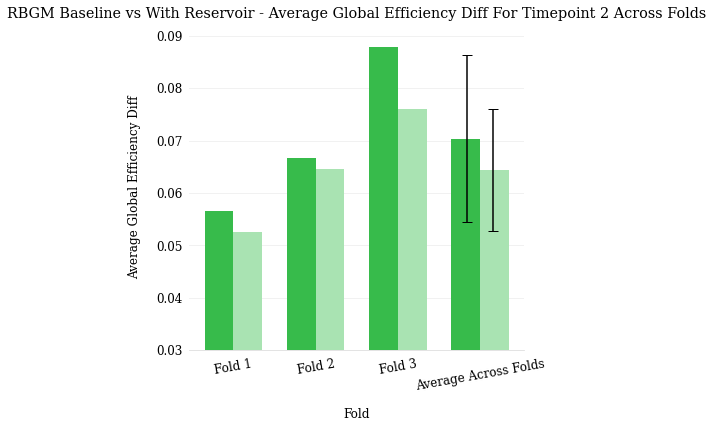

In [64]:
title = 'RBGM Baseline vs With Reservoir - Average Global Efficiency Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_global_efficiency_diff, baseline_global_efficiency_diff, title, 'Average Global Efficiency Diff', 0, (0.02,), palette_efficiency)
title = 'RBGM Baseline vs With Reservoir - Average Global Efficiency Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_global_efficiency_diff, baseline_global_efficiency_diff, title, 'Average Global Efficiency Diff', 1, (0.03,), palette_efficiency)

In [54]:
reservoir_local_efficiency_diff = get_diffs_across_folds(local_efficiency_diff, predicted_across_all_folds, original_across_all_folds)
baseline_local_efficiency_diff = get_diffs_across_folds(local_efficiency_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 0.013205480059573315
Standard Deviation 0.002335093464018297
Baseline Mean: 0.01342907986384202
Baseline Standard Deviation 0.002557248286241015


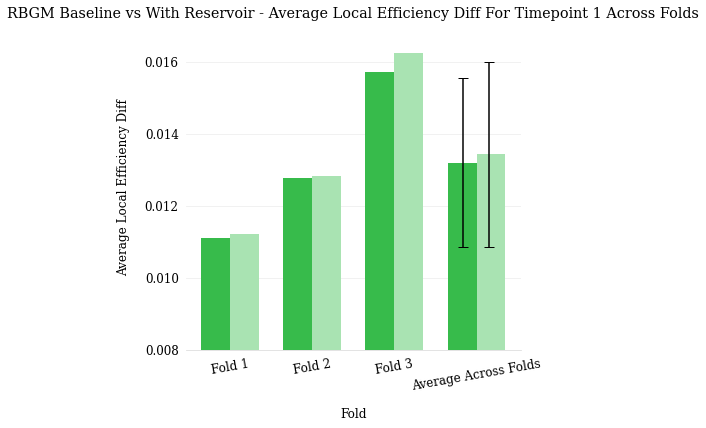

Mean: 0.02445782866020354
Standard Deviation 0.009567236778371095
Baseline Mean: 0.02283758649716303
Baseline Standard Deviation 0.005787412794376791


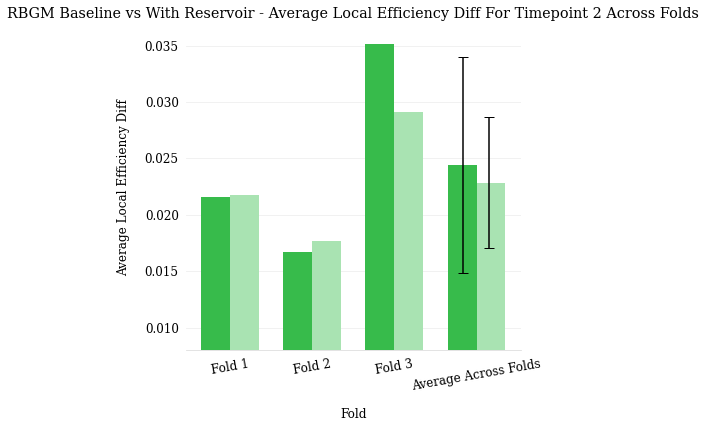

In [65]:
title = 'RBGM Baseline vs With Reservoir - Average Local Efficiency Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_local_efficiency_diff, baseline_local_efficiency_diff, title, 'Average Local Efficiency Diff', 0, (0.008,), palette_efficiency)
title = 'RBGM Baseline vs With Reservoir - Average Local Efficiency Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_local_efficiency_diff, baseline_local_efficiency_diff, title, 'Average Local Efficiency Diff', 1, (0.008,), palette_efficiency)

### Modularity

In [56]:
reservoir_modularity_diff = get_diffs_across_folds(modularity_diff, predicted_across_all_folds, original_across_all_folds)
baseline_modularity_diff = get_diffs_across_folds(modularity_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 0.008859386696913586
Standard Deviation 0.00037679676712800005
Baseline Mean: 0.009387797071614683
Baseline Standard Deviation 0.0015050428352408028


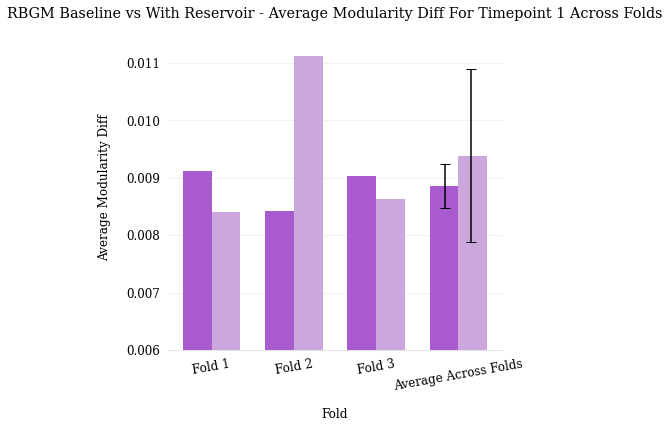

Mean: 0.007390298447239996
Standard Deviation 0.0012506563735378735
Baseline Mean: 0.006387668894020597
Baseline Standard Deviation 0.0013884059038800406


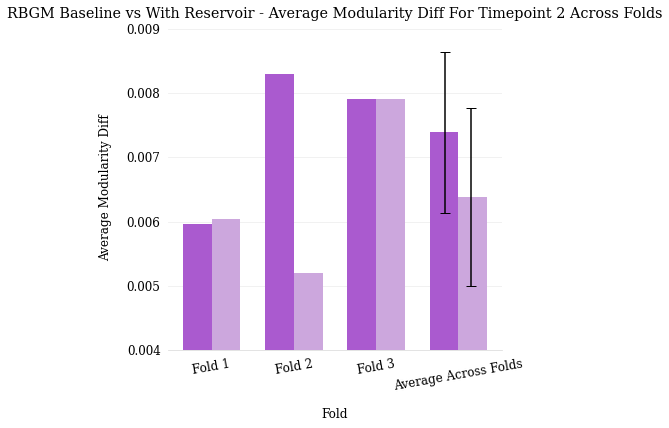

In [66]:
title = 'RBGM Baseline vs With Reservoir - Average Modularity Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_modularity_diff, baseline_modularity_diff, title, 'Average Modularity Diff', 0, (0.006,), palette_global)
title = 'RBGM Baseline vs With Reservoir - Average Modularity Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_modularity_diff, baseline_modularity_diff, title, 'Average Modularity Diff', 1, (0.004,), palette_global)           

### Density

Mean: 0.04706320650593096
Standard Deviation 0.008420164762350755
Baseline Mean: 0.05093138251032988
Baseline Standard Deviation 0.009648443199721706


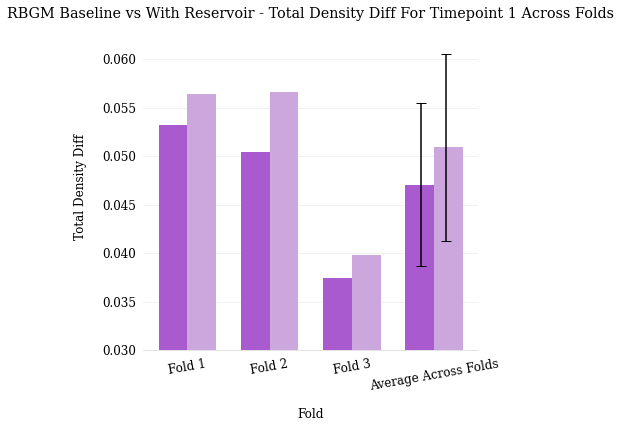

Mean: 0.03362778966494136
Standard Deviation 0.0070644002432480235
Baseline Mean: 0.03910770567117315
Baseline Standard Deviation 0.013041566224966841


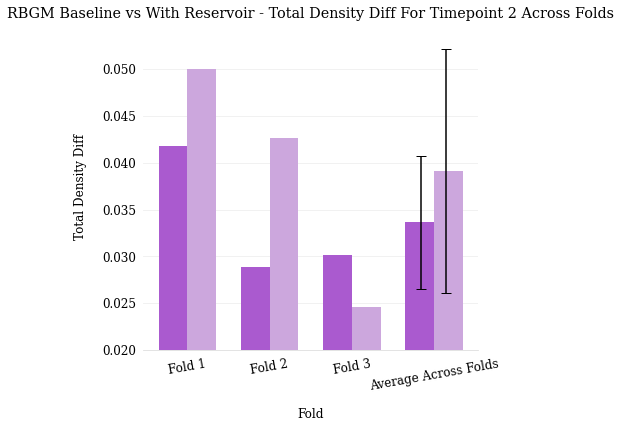

In [67]:
reservoir_density_diff = get_diffs_across_folds(density_diff, predicted_across_all_folds, original_across_all_folds)
baseline_density_diff = get_diffs_across_folds(density_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'RBGM Baseline vs With Reservoir - Total Density Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_density_diff, baseline_density_diff, title, 'Total Density Diff', 0, (0.03,), palette_global)
title = 'RBGM Baseline vs With Reservoir - Total Density Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_density_diff, baseline_density_diff, title, 'Total Density Diff', 1, (0.02,), palette_global)


### Clustering

Mean: 0.012650409795160772
Standard Deviation 0.0025957536549263294
Baseline Mean: 0.013060648762713596
Baseline Standard Deviation 0.002592758771513354


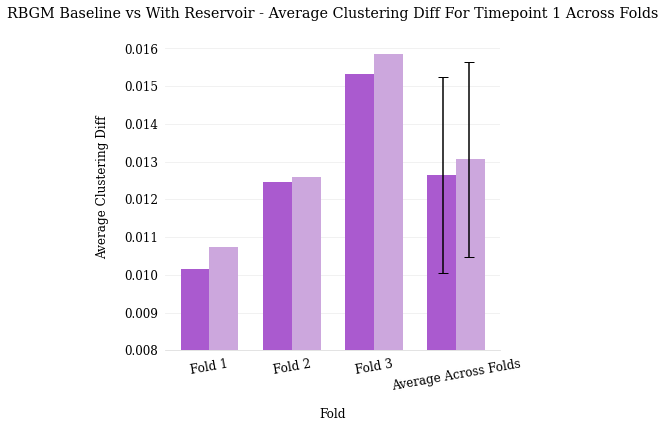

Mean: 0.026208876712130538
Standard Deviation 0.0110633637560883
Baseline Mean: 0.023635332840869393
Baseline Standard Deviation 0.007778010278306771


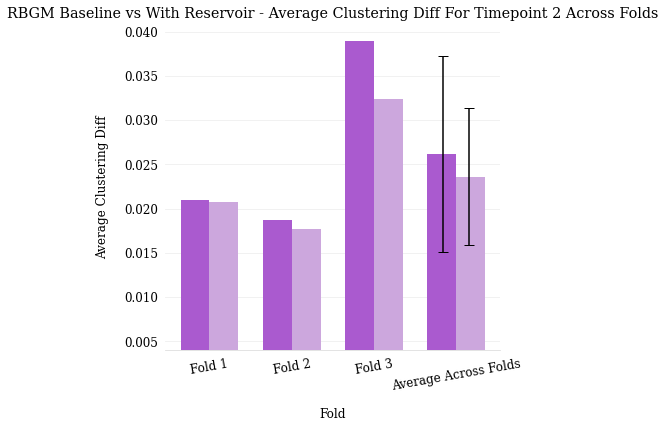

In [68]:
reservoir_clustering_diff = get_diffs_across_folds(clustering_diff, predicted_across_all_folds, original_across_all_folds)
baseline_clustering_diff = get_diffs_across_folds(clustering_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

title = 'RBGM Baseline vs With Reservoir - Average Clustering Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_clustering_diff, baseline_clustering_diff, title, 'Average Clustering Diff', 0, (0.008,), palette_global)
title = 'RBGM Baseline vs With Reservoir - Average Clustering Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_clustering_diff, baseline_clustering_diff, title, 'Average Clustering Diff', 1, (0.004,), palette_global)

## Identity

In [77]:
file_path = '/vol/bitbucket/sx420/4D-FedGNN-Plus/results/baseline_identity_oasis/'
mae_across_all_folds, mem_cap_across_all_folds,\
predicted_across_all_folds, original_across_all_folds = load_test_results(file_path, 5, 38, 2)

In [78]:
print_mean_std(mae_across_all_folds[:, 0],mae_across_all_folds[:, 1])

Mean: 0.03971950487185844
Standard Deviation 0.006198854164926211
Baseline Mean: 0.047235162031980374
Baseline Standard Deviation 0.006379941458124997


(0.03971950487185844,
 0.047235162031980374,
 0.006198854164926211,
 0.006379941458124997)

In [79]:
print_mean_std(mem_cap_across_all_folds[:, 0],mem_cap_across_all_folds[:, 1])

Mean: 0.2955616630927133
Standard Deviation 0.03110759108903918
Baseline Mean: 0.27254894973252386
Baseline Standard Deviation 0.0618868022082053


(0.2955616630927133,
 0.27254894973252386,
 0.03110759108903918,
 0.0618868022082053)

Mean: 0.04265302077691778
Standard Deviation 0.003984261540234798
Baseline Mean: 0.04295309265963327
Baseline Standard Deviation 0.00342726753817769


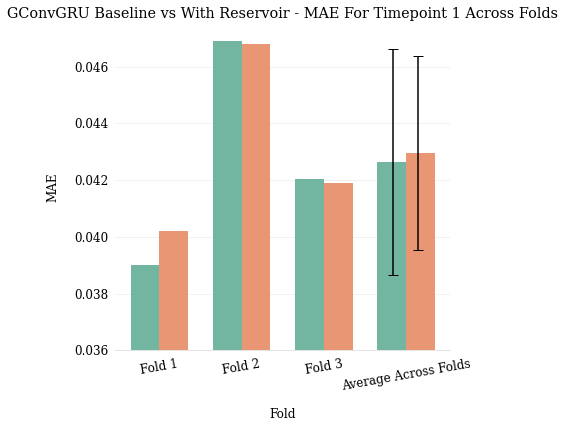

Mean: 0.04642811031802789
Standard Deviation 0.0039041214086026382
Baseline Mean: 0.04679213558231388
Baseline Standard Deviation 0.0034208058355895275


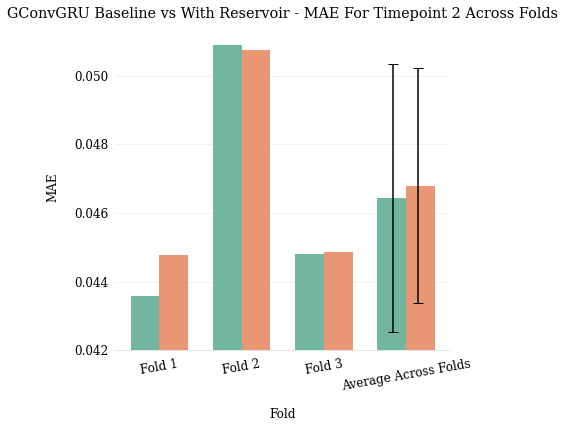

Mean: 0.5619062823047675
Standard Deviation 0.0868208694302811
Baseline Mean: 0.7148975742120527
Baseline Standard Deviation 0.1591331517119297


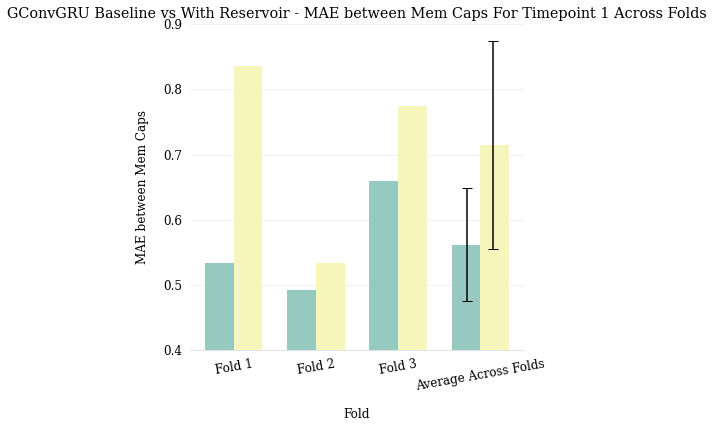

Mean: 0.6169850175677638
Standard Deviation 0.15616982549867786
Baseline Mean: 0.6769517698070726
Baseline Standard Deviation 0.1683991903403402


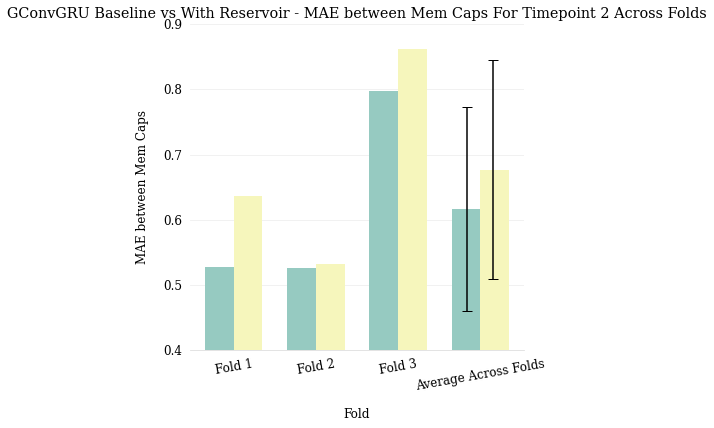

In [51]:
# GConvGRU

file_path = '/vol/bitbucket/sx420/4D-FedGNN-Plus/results/reservoir_gconvGRU_language_1/'
mae_across_all_folds, mem_cap_across_all_folds,\
predicted_across_all_folds, original_across_all_folds = load_test_results(file_path, 3, 38, 2)

baseline_file_path = '/vol/bitbucket/sx420/4D-FedGNN-Plus/results/baseline_gconvGRU_language_2/'
baseline_mae_across_all_folds, baseline_mem_cap_across_all_folds,\
baseline_predicted_across_all_folds, baseline_original_across_all_folds = load_test_results(baseline_file_path, 3, 38, 2)

## MAE

title = 'GConvGRU Baseline vs With Reservoir - MAE For Timepoint 1 Across Folds'
plot_comparison(mae_across_all_folds, baseline_mae_across_all_folds, title, 'MAE', 0, (0.036, 0.0475))

title = 'GConvGRU Baseline vs With Reservoir - MAE For Timepoint 2 Across Folds'
plot_comparison(mae_across_all_folds, baseline_mae_across_all_folds, title, 'MAE', 1, (0.042, 0.0515))

## MAE between Mem Caps

title = 'GConvGRU Baseline vs With Reservoir - MAE between Mem Caps For Timepoint 1 Across Folds'
plot_comparison(mem_cap_across_all_folds, baseline_mem_cap_across_all_folds, title, 'MAE between Mem Caps', 0, (0.4,0.9), 'Set3')

title = 'GConvGRU Baseline vs With Reservoir - MAE between Mem Caps For Timepoint 2 Across Folds'
plot_comparison(mem_cap_across_all_folds, baseline_mem_cap_across_all_folds, title, 'MAE between Mem Caps', 1, (0.4,0.9), 'Set3')

### Node Strength

Mean: 0.5689688495343912
Standard Deviation 0.21655788451248184
Baseline Mean: 0.5710781503757411
Baseline Standard Deviation 0.18563499384974425


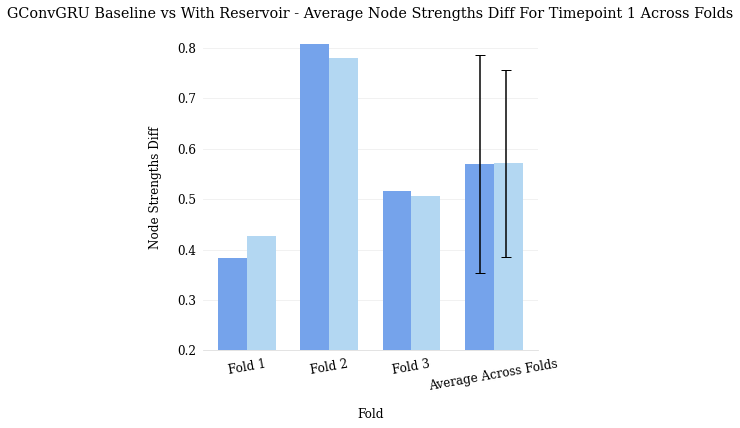

Mean: 0.7179996390842652
Standard Deviation 0.23352216802137846
Baseline Mean: 0.7299501523571749
Baseline Standard Deviation 0.19340391890635858


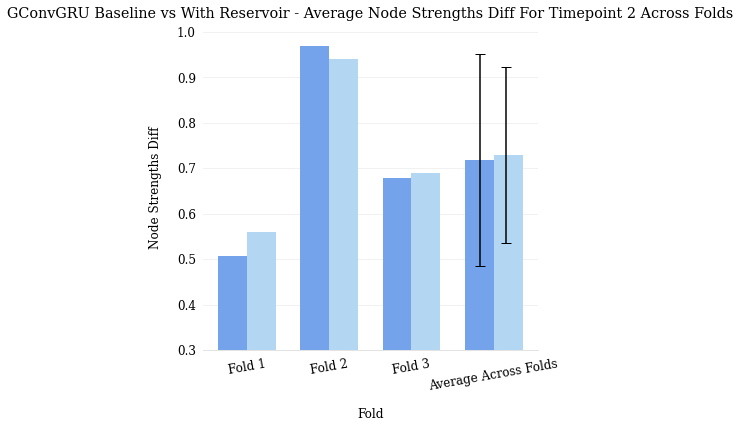

In [46]:
reservoir_node_strength_diff = get_diffs_across_folds(node_strength_diff, predicted_across_all_folds, original_across_all_folds)
baseline_node_strength_diff = get_diffs_across_folds(node_strength_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'GConvGRU Baseline vs With Reservoir - Average Node Strengths Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_node_strength_diff, baseline_node_strength_diff, title, 'Node Strengths Diff', 0, (0.2,), palette_nodewise)
title = 'GConvGRU Baseline vs With Reservoir - Average Node Strengths Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_node_strength_diff, baseline_node_strength_diff, title, 'Node Strengths Diff', 1, (0.3,), palette_nodewise)

### Centrality

Mean: 0.005990578873149477
Standard Deviation 0.001356336266846354
Baseline Mean: 0.005749997412972082
Baseline Standard Deviation 0.002164363740474163


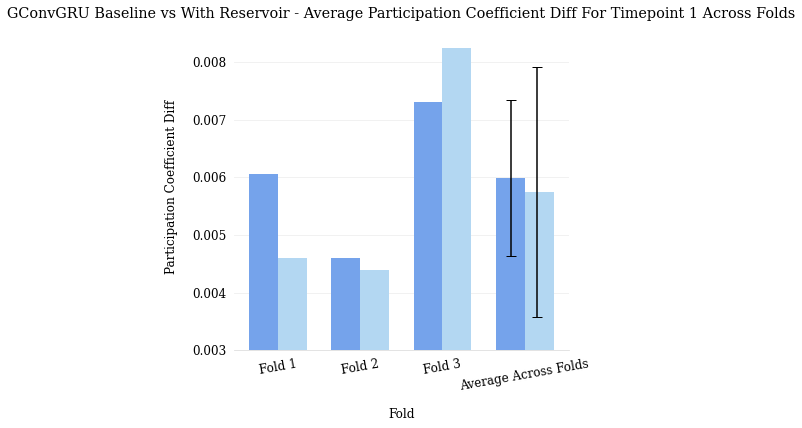

Mean: 0.00669007020285588
Standard Deviation 0.0006354911830737815
Baseline Mean: 0.006582449672925773
Baseline Standard Deviation 0.000794464940428165


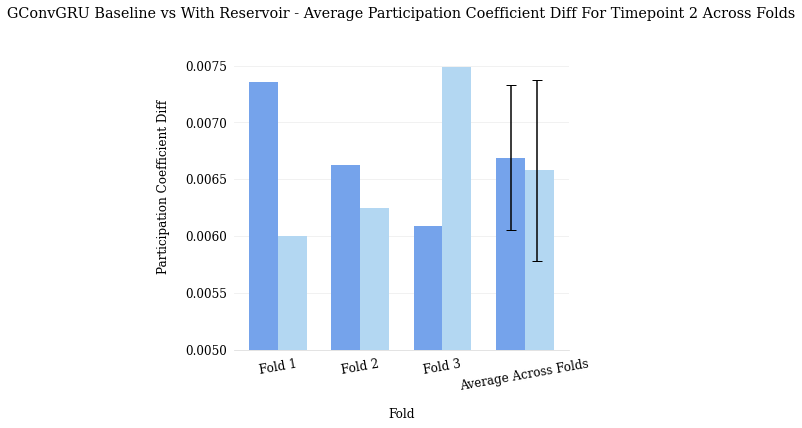

In [27]:
reservoir_participation_coef_diff = get_diffs_across_folds(participation_coef_diff, predicted_across_all_folds, original_across_all_folds)
baseline_participation_coef_diff = get_diffs_across_folds(participation_coef_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'GConvGRU Baseline vs With Reservoir - Average Participation Coefficient Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_participation_coef_diff, baseline_participation_coef_diff, title, 'Participation Coefficient Diff', 0, (0.003, ), palette_nodewise)
title = 'GConvGRU Baseline vs With Reservoir - Average Participation Coefficient Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_participation_coef_diff, baseline_participation_coef_diff, title, 'Participation Coefficient Diff', 1, (0.005,), palette_nodewise)

Mean: 0.0262043080000043
Standard Deviation 0.005541226902404774
Baseline Mean: 0.02399307555392248
Baseline Standard Deviation 0.008434158710077943


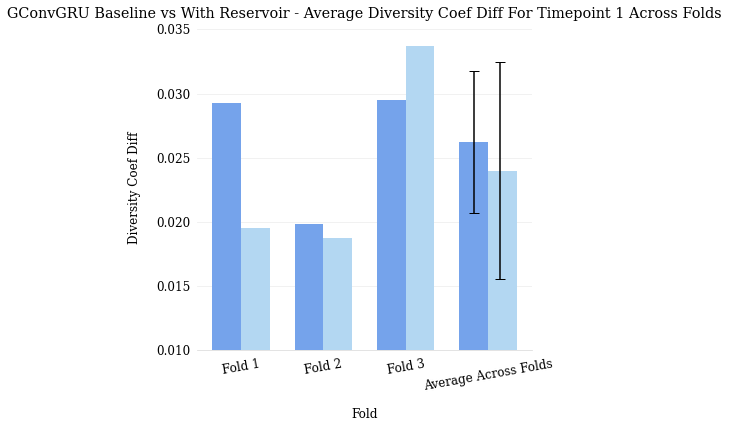

Mean: 0.02806957805592936
Standard Deviation 0.005059745373736613
Baseline Mean: 0.02637658585814319
Baseline Standard Deviation 0.005613432253355808


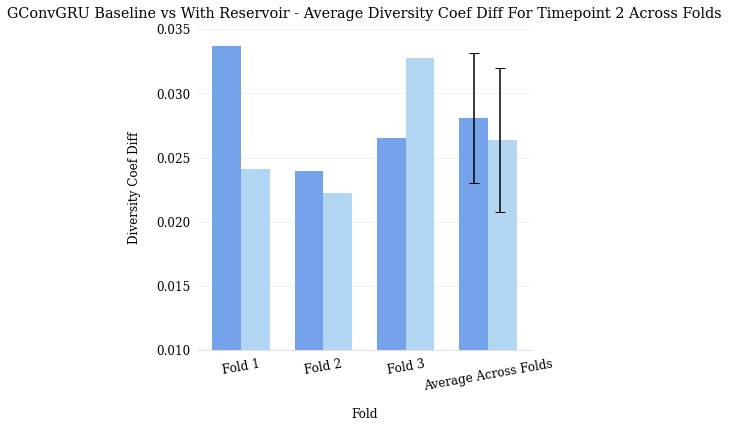

In [28]:
reservoir_diversity_coef_diff = get_diffs_across_folds(diversity_coef_diff, predicted_across_all_folds, original_across_all_folds)
baseline_diversity_coef_diff = get_diffs_across_folds(diversity_coef_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'GConvGRU Baseline vs With Reservoir - Average Diversity Coef Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_diversity_coef_diff, baseline_diversity_coef_diff, title, 'Diversity Coef Diff', 0, (0.01,), palette_nodewise)
title = 'GConvGRU Baseline vs With Reservoir - Average Diversity Coef Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_diversity_coef_diff, baseline_diversity_coef_diff, title, 'Diversity Coef Diff', 1, (0.01,), palette_nodewise)

In [29]:
reservoir_betweeness_centrality_diff = get_diffs_across_folds(betweeness_centrality_diff, predicted_across_all_folds, original_across_all_folds)
baseline_betweeness_centrality_diff = get_diffs_across_folds(betweeness_centrality_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 76.93815639289323
Standard Deviation 2.0263293611546973
Baseline Mean: 77.44782922361871
Baseline Standard Deviation 1.631589690494404


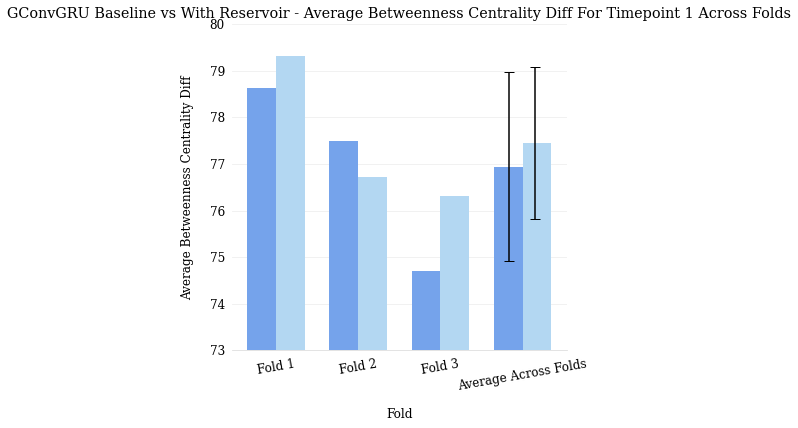

Mean: 81.76038733189111
Standard Deviation 2.5780961234184723
Baseline Mean: 82.60595395114193
Baseline Standard Deviation 2.5280000265044595


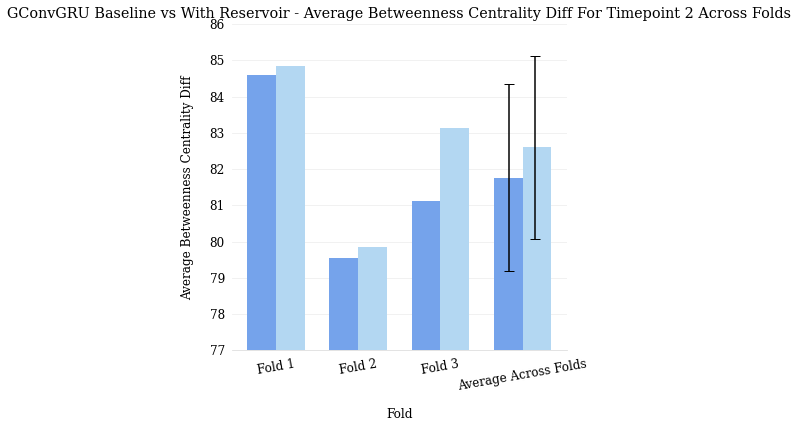

In [53]:
title = 'GConvGRU Baseline vs With Reservoir - Average Betweenness Centrality Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_betweeness_centrality_diff, baseline_betweeness_centrality_diff, title, 'Average Betweenness Centrality Diff', 0, (73,80), palette_nodewise)
title = 'GConvGRU Baseline vs With Reservoir - Average Betweenness Centrality Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_betweeness_centrality_diff, baseline_betweeness_centrality_diff, title, 'Average Betweenness Centrality Diff', 1, (77,86), palette_nodewise)

Mean: 0.003087661268732599
Standard Deviation 0.0004512241198263254
Baseline Mean: 0.0030866157202110085
Baseline Standard Deviation 0.0004420794487074157


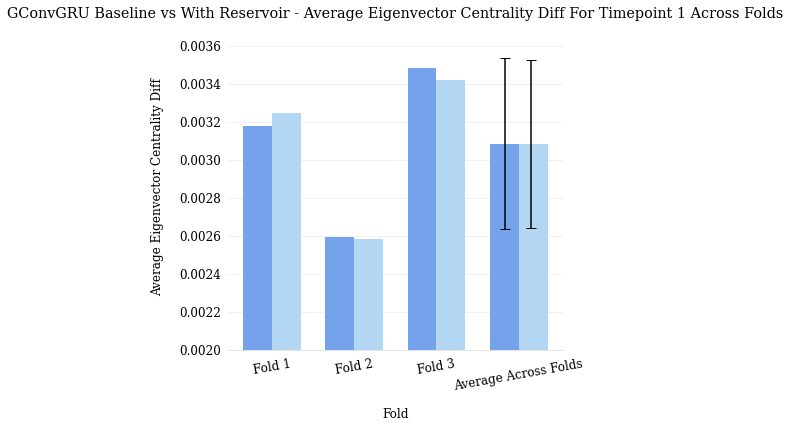

Mean: 0.004357553038693529
Standard Deviation 0.00030402374855227637
Baseline Mean: 0.004376335369972746
Baseline Standard Deviation 0.0004698059785761384


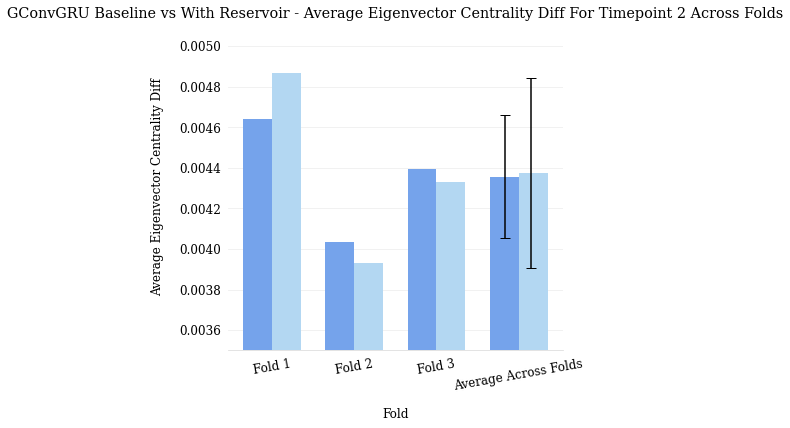

In [54]:
reservoir_eigenvector_centrality_diff = get_diffs_across_folds(eigenvector_centrality_diff, predicted_across_all_folds, original_across_all_folds)
baseline_eigenvector_centrality_diff = get_diffs_across_folds(eigenvector_centrality_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'GConvGRU Baseline vs With Reservoir - Average Eigenvector Centrality Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_eigenvector_centrality_diff, baseline_eigenvector_centrality_diff, title, 'Average Eigenvector Centrality Diff', 0, (0.002,), palette_nodewise)
title = 'GConvGRU Baseline vs With Reservoir - Average Eigenvector Centrality Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_eigenvector_centrality_diff, baseline_eigenvector_centrality_diff, title, 'Average Eigenvector Centrality Diff', 1, (0.0035,), palette_nodewise)

### Efficiency

In [36]:
reservoir_global_efficiency_diff = get_diffs_across_folds(global_efficiency_diff, predicted_across_all_folds, original_across_all_folds)
baseline_global_efficiency_diff = get_diffs_across_folds(global_efficiency_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 0.05073667233087061
Standard Deviation 0.010889887101425508
Baseline Mean: 0.05141636589383075
Baseline Standard Deviation 0.008479220012982147


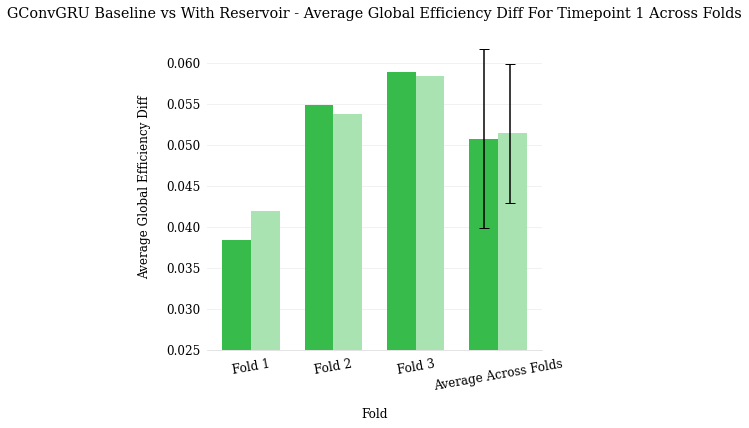

Mean: 0.0647373205186838
Standard Deviation 0.015821225063357758
Baseline Mean: 0.06602320367737896
Baseline Standard Deviation 0.013526117532221136


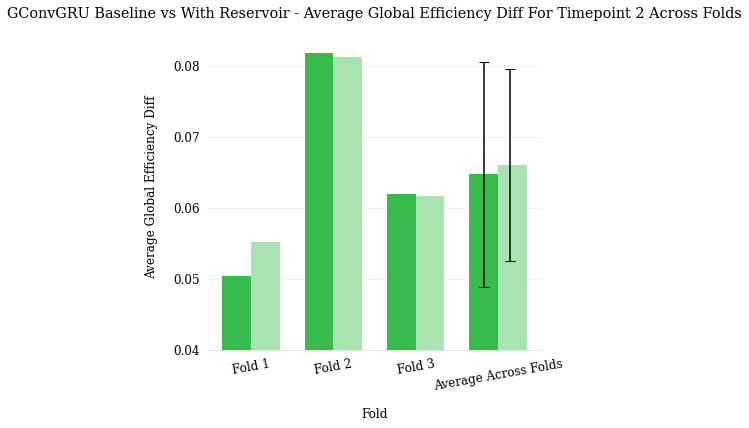

In [55]:
title = 'GConvGRU Baseline vs With Reservoir - Average Global Efficiency Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_global_efficiency_diff, baseline_global_efficiency_diff, title, 'Average Global Efficiency Diff', 0, (0.025,), palette_efficiency)
title = 'GConvGRU Baseline vs With Reservoir - Average Global Efficiency Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_global_efficiency_diff, baseline_global_efficiency_diff, title, 'Average Global Efficiency Diff', 1, (0.04,), palette_efficiency)

In [38]:
reservoir_local_efficiency_diff = get_diffs_across_folds(local_efficiency_diff, predicted_across_all_folds, original_across_all_folds)
baseline_local_efficiency_diff = get_diffs_across_folds(local_efficiency_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 0.011611017520509727
Standard Deviation 0.0034407975065574247
Baseline Mean: 0.011497510297250926
Baseline Standard Deviation 0.0032546277736066665


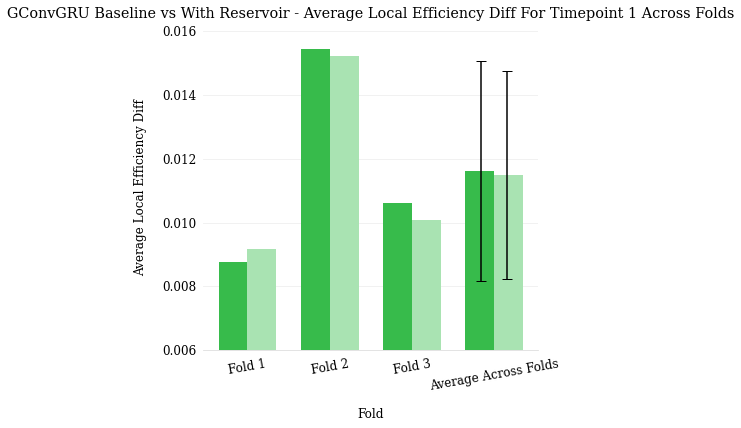

Mean: 0.014580487424534008
Standard Deviation 0.004136396636434251
Baseline Mean: 0.01452062756063484
Baseline Standard Deviation 0.004213323206908023


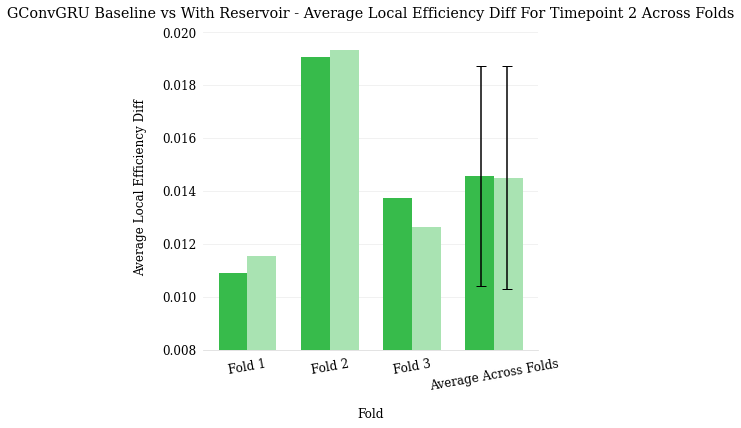

In [39]:
title = 'GConvGRU Baseline vs With Reservoir - Average Local Efficiency Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_local_efficiency_diff, baseline_local_efficiency_diff, title, 'Average Local Efficiency Diff', 0, (0.006,), palette_efficiency)
title = 'GConvGRU Baseline vs With Reservoir - Average Local Efficiency Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_local_efficiency_diff, baseline_local_efficiency_diff, title, 'Average Local Efficiency Diff', 1, (0.008,), palette_efficiency)

### Modularity

In [32]:
reservoir_modularity_diff = get_diffs_across_folds(modularity_diff, predicted_across_all_folds, original_across_all_folds)
baseline_modularity_diff = get_diffs_across_folds(modularity_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 0.002892754586108733
Standard Deviation 7.22011950402154e-05
Baseline Mean: 0.0027019242170517946
Baseline Standard Deviation 0.00021474046722051807


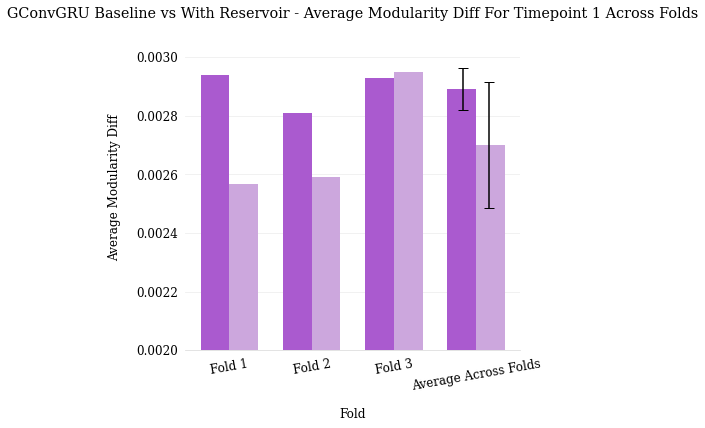

Mean: 0.003794356466793014
Standard Deviation 0.0009220922282998672
Baseline Mean: 0.0036201952387823074
Baseline Standard Deviation 0.0004235918830627427


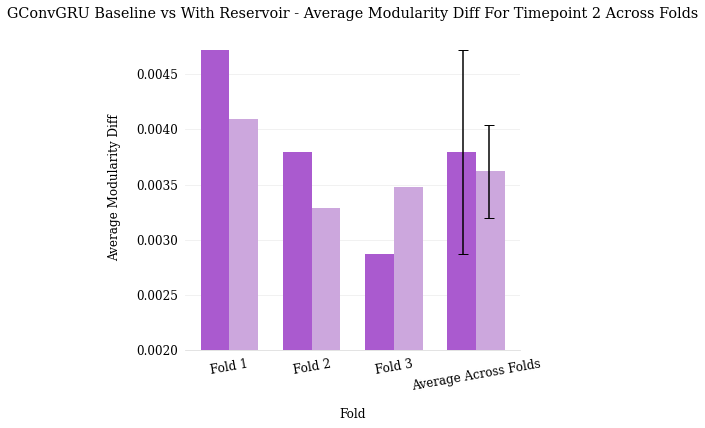

In [56]:
title = 'GConvGRU Baseline vs With Reservoir - Average Modularity Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_modularity_diff, baseline_modularity_diff, title, 'Average Modularity Diff', 0, (0.002,), palette_global)
title = 'GConvGRU Baseline vs With Reservoir - Average Modularity Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_modularity_diff, baseline_modularity_diff, title, 'Average Modularity Diff', 1, (0.002,), palette_global)           

### Density

Mean: 0.04996274469958685
Standard Deviation 0.0011618486958960895
Baseline Mean: 0.04887178199871703
Baseline Standard Deviation 0.0015257653844274735


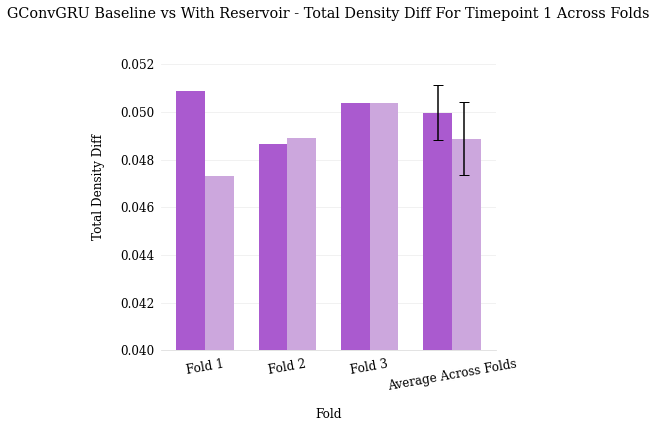

Mean: 0.05021376971841372
Standard Deviation 0.0010328338427325354
Baseline Mean: 0.04897537962553447
Baseline Standard Deviation 0.0016697738622754223


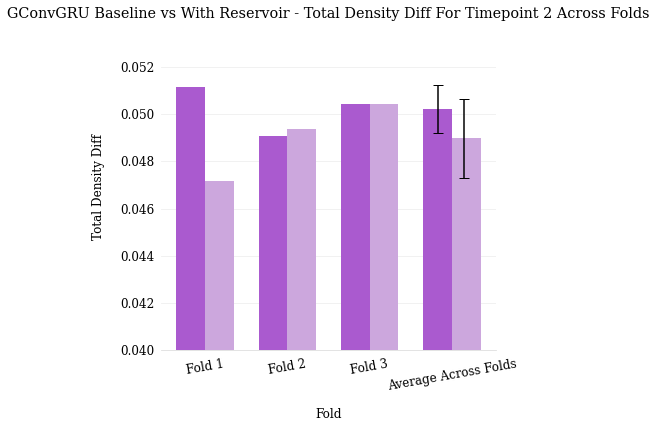

In [47]:
reservoir_density_diff = get_diffs_across_folds(density_diff, predicted_across_all_folds, original_across_all_folds)
baseline_density_diff = get_diffs_across_folds(density_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'GConvGRU Baseline vs With Reservoir - Total Density Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_density_diff, baseline_density_diff, title, 'Total Density Diff', 0, (0.04,), palette_global)
title = 'GConvGRU Baseline vs With Reservoir - Total Density Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_density_diff, baseline_density_diff, title, 'Total Density Diff', 1, (0.04,), palette_global)


### Clustering

Mean: 0.010906337548804079
Standard Deviation 0.003570099121896933
Baseline Mean: 0.011079131518451924
Baseline Standard Deviation 0.0032765539883512196


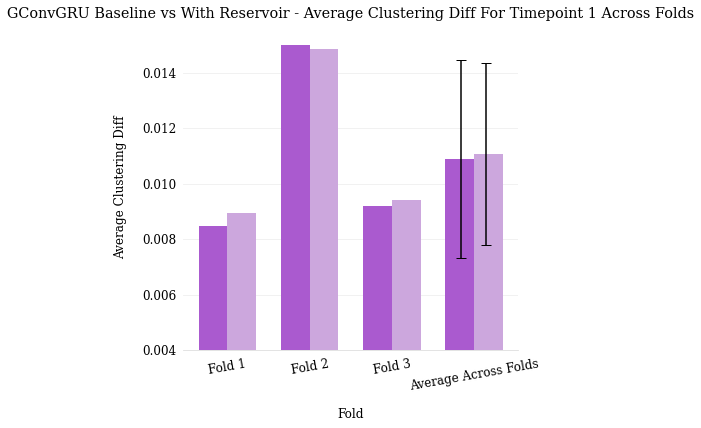

Mean: 0.013644294623263853
Standard Deviation 0.004442792955255471
Baseline Mean: 0.013762851112184551
Baseline Standard Deviation 0.0045304689474882955


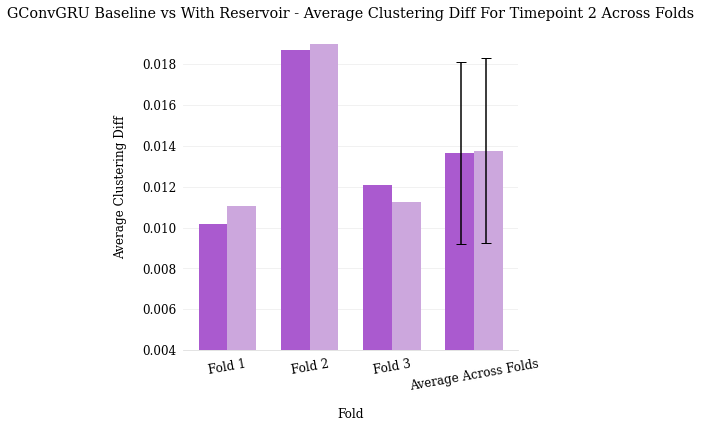

In [35]:
reservoir_clustering_diff = get_diffs_across_folds(clustering_diff, predicted_across_all_folds, original_across_all_folds)
baseline_clustering_diff = get_diffs_across_folds(clustering_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

title = 'GConvGRU Baseline vs With Reservoir - Average Clustering Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_clustering_diff, baseline_clustering_diff, title, 'Average Clustering Diff', 0, (0.004,), palette_global)
title = 'GConvGRU Baseline vs With Reservoir - Average Clustering Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_clustering_diff, baseline_clustering_diff, title, 'Average Clustering Diff', 1, (0.004,), palette_global)